# Over dit document
In dit document wordt een CRISP-DM cycle doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en een advies gegeven. Bij dit advies zal het ethische aspect meegenomen worden en dat zal de meeste nadruk krijgen. Hiervoor is ter ondersteuning het Data Ethics Decision Aid model (DEDA model) voor gebruikt.

Auteur: Eefkje-Femke Jansen van der Sligte

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")


# Business understanding
Het Isala ziekenhuis wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces. Door onnauwkeurigheden in metingen te filteren en hierop een behandelplan aan te passen, zal er een verbetering optreden in de analyse. Visualisaties zullen helpen bij het verkrijgen van inzicht in de foutmarges van diverse meetmethoden. Op dit moment zijn er geen visualisaties die dat in kaart brengen. Een visualisatie van een voorspelling zou meer inzicht kunnen brengen in hoe de 'total error' zal veranderen. Dit zou kunnen resulteren in daarop afgestemde toekomstige plannen voor het standaardiseren van de HbA1c meetmethoden.

Om een voorspelling te realiseren & visualiseren wordt het ARIMA model gebruikt. Als eerste wordt er gekeken naar hoe stationair de data is. Vervolgens zullen de parameters (zie uitleg ARIMA model) voor dit model worden afgestemd op verschillende grafieken. Tot slot zal de voorspelling gevisualiseerd worden.

#### Uitleg ARIMA model
Het doel van een ARIMA model (ARIMA(p=?, d=?,q=?)) is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 


Door deze effecten te mengen kun je de meeste tijdseries nabootsen. In de daaropvolgende fases gaan we de effecten van de AR en MA termen op een tijdseries bekijken. 

Note

In dit notebook zal er gefocust worden op het ARIMA model. Het aantal metingen per fabrikant verschilt enorm. Daarom wordt er nu gefocust op de top 10 fabrikanten met de meeste metingen. 

# Data understanding
Welke databronnen zijn gegeven en in welk formaat:
Een excel bestand genaamd: Complete-dataset-FINAL.xlsx
##### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die zijn omgezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen:
355 kB

-4685 rijen

-12 kolommen



Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).
- Method name : Naam van het meetmethode
- N	: Aantal deelgenomen labs
- Mean :  Gemiddelde van alle HbA1c waarde
- Bias : Absolute toe- of afname van de hoeveelheid mmol/mol ten opzichte van de werkelijke waarde
- CV : Laat zien wat de spreiding is de metingen
- Sample : Hoeveelste meting in het jaar
- Reference Value : Variabel die is gebaseerd op 95% van de gezonde populatie		
- Year : Welk jaar de meting is gedaan
- Source	: Amerikaanse of Europese data
- Type : Vers of bevroren samples

Datatypes: Object, float en int (jaar) 

# Data preparation
De dataset wordt aangepast, zodat het bruikbaar is om tijdsreeksen mee te kunnen voorspellen.

In [20]:
#Check to drop all empty values, adjust column name so it's usable
df=df.dropna()
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [21]:
df.Year.astype('int32')
df['Year'] =pd.to_datetime(df.Year, format='%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4058 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Method name          4058 non-null   object        
 1   N (no. labs)         4058 non-null   object        
 2   Mean                 4058 non-null   float64       
 3   Bias                 4058 non-null   float64       
 4   CV                   4058 non-null   float64       
 5   Sample               4058 non-null   object        
 6   Reference Value      4058 non-null   float64       
 7   Year                 4058 non-null   datetime64[ns]
 8   Source (CAP/EurA1c)  4058 non-null   object        
 9   Type (Fresh/frozen)  4058 non-null   object        
 10  Manufacturer         4058 non-null   object        
 11  Total                4058 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 412.1+ KB


In [22]:
df = df.set_index('Year')
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total
Year,,,,,,,,,,,
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,CAP,Fresh,Vitros,4.348
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,CAP,Fresh,Vitros,4.890
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,CAP,Fresh,Vitros,6.100
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,CAP,Fresh,Vitros,4.328
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,CAP,Fresh,Vitros,5.036


In [23]:
# predict only top 10 manufacturers with most datapoints
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3737 entries, 2011-01-01 to 2021-01-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          3737 non-null   object 
 1   N (no. labs)         3737 non-null   object 
 2   Mean                 3737 non-null   float64
 3   Bias                 3737 non-null   float64
 4   CV                   3737 non-null   float64
 5   Sample               3737 non-null   object 
 6   Reference Value      3737 non-null   float64
 7   Source (CAP/EurA1c)  3737 non-null   object 
 8   Type (Fresh/frozen)  3737 non-null   object 
 9   Manufacturer         3737 non-null   object 
 10  Total                3737 non-null   float64
dtypes: float64(5), object(6)
memory usage: 350.3+ KB


In [24]:
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total']]
manufacturers = top10_manufacturers.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
dtype: int64

Abbott


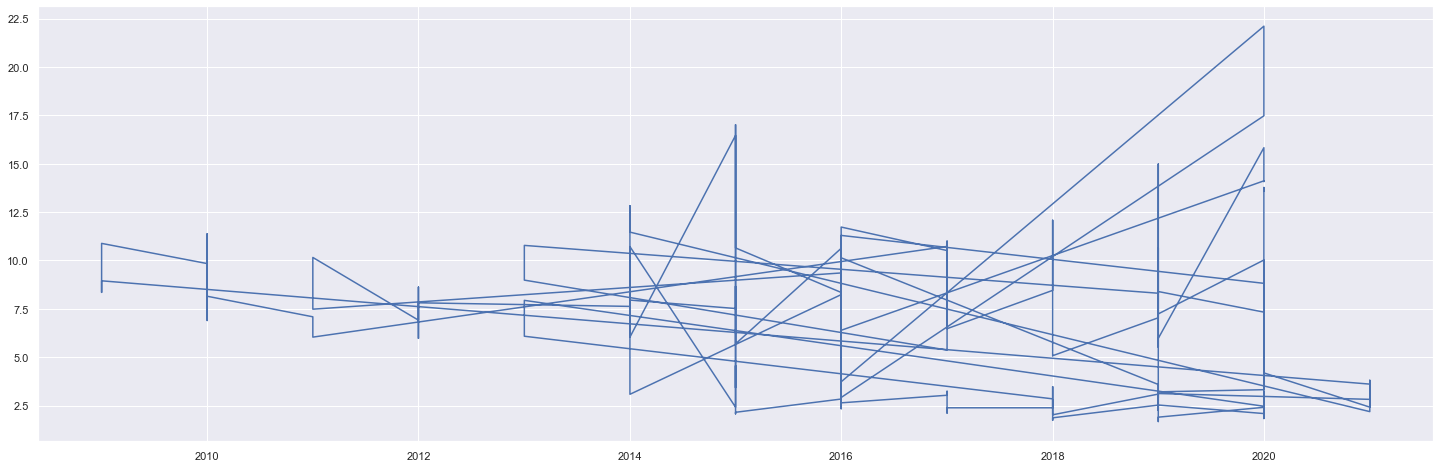

Alere


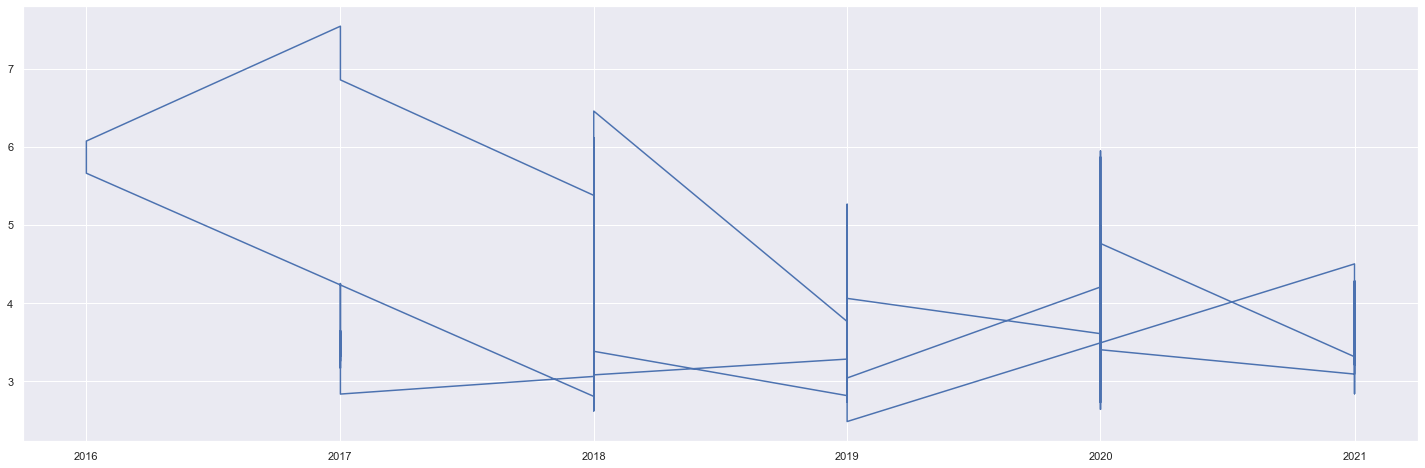

Beckman Coulter


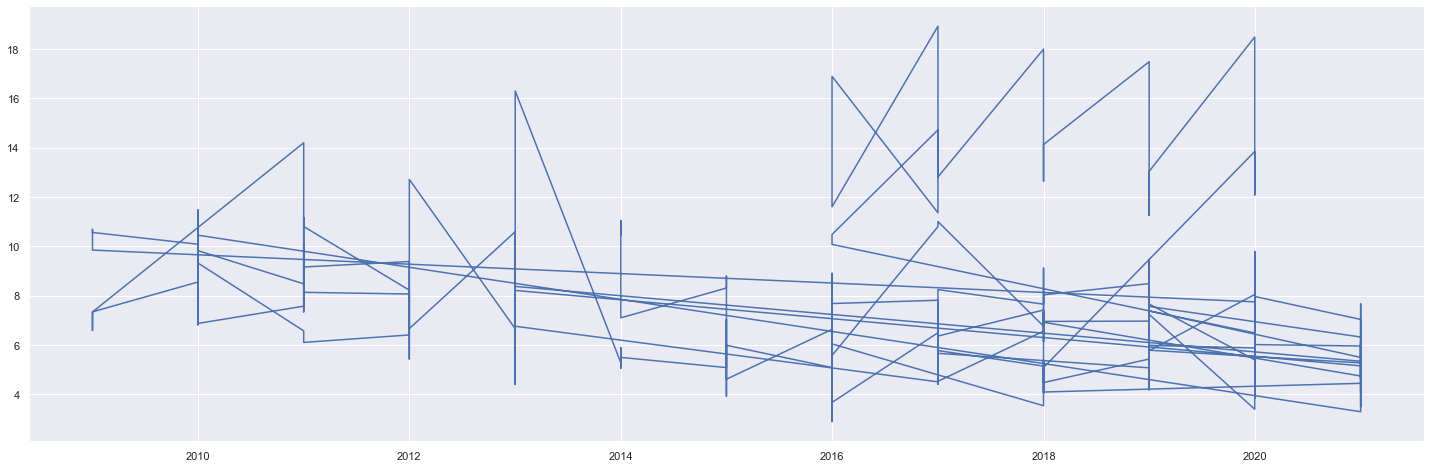

Bio-Rad


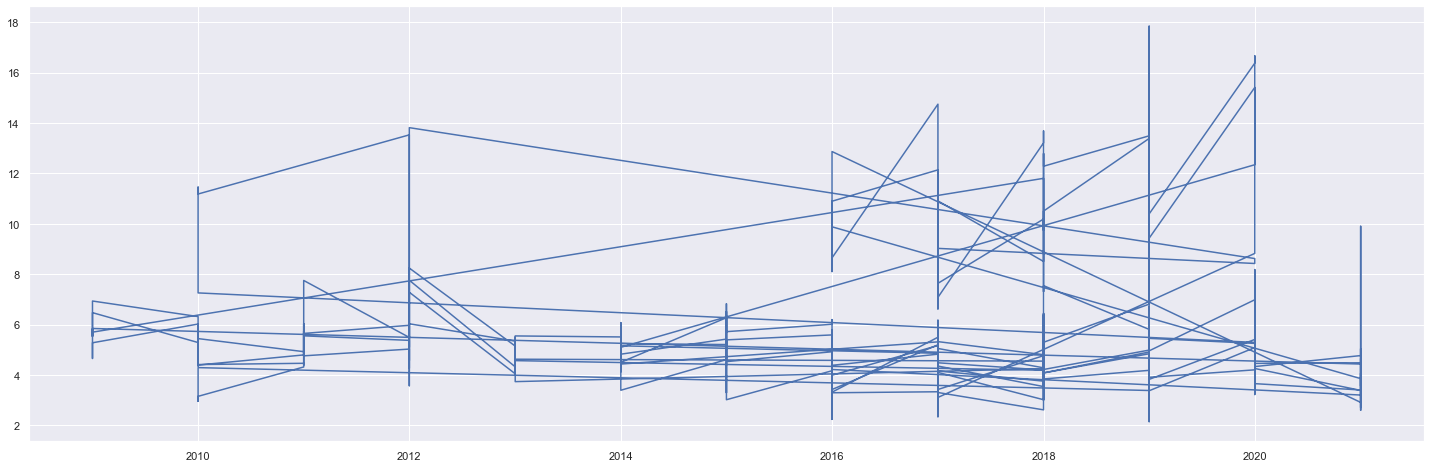

Roche Diagnostics


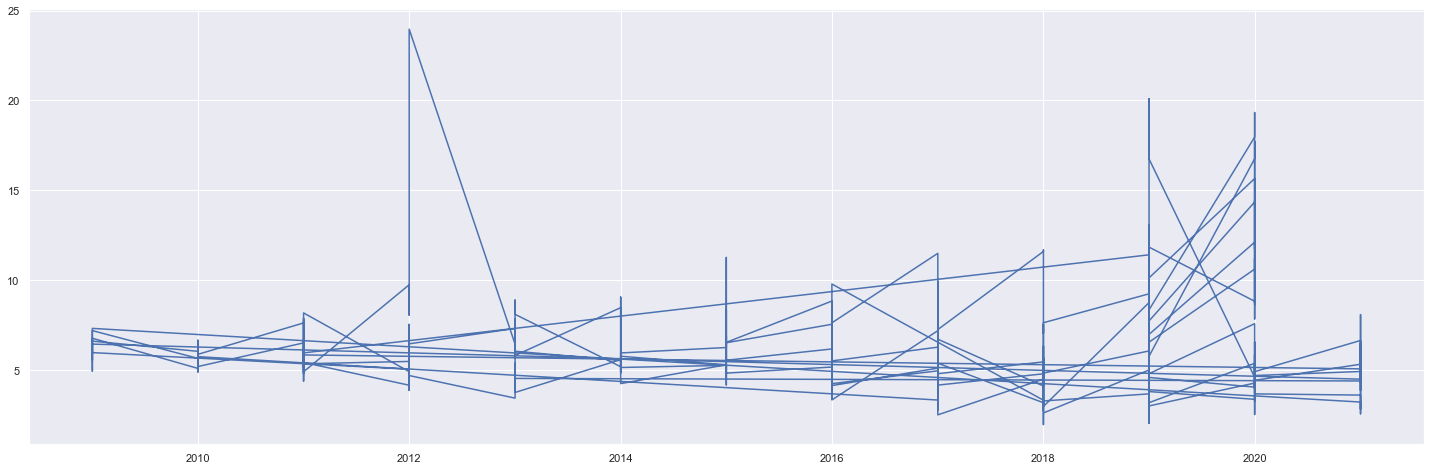

Sebia


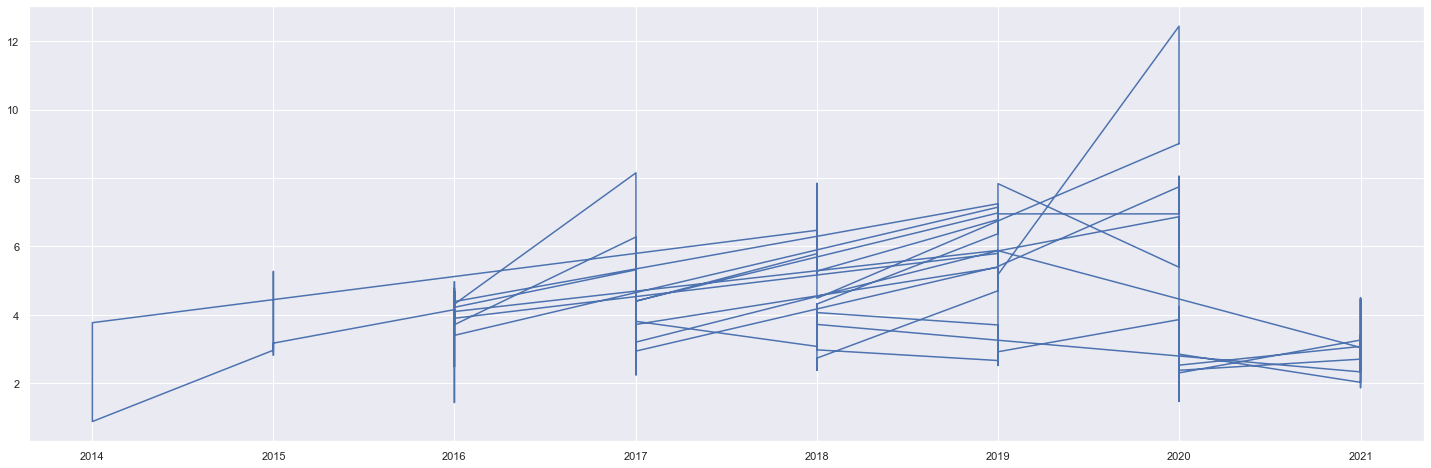

Siemens


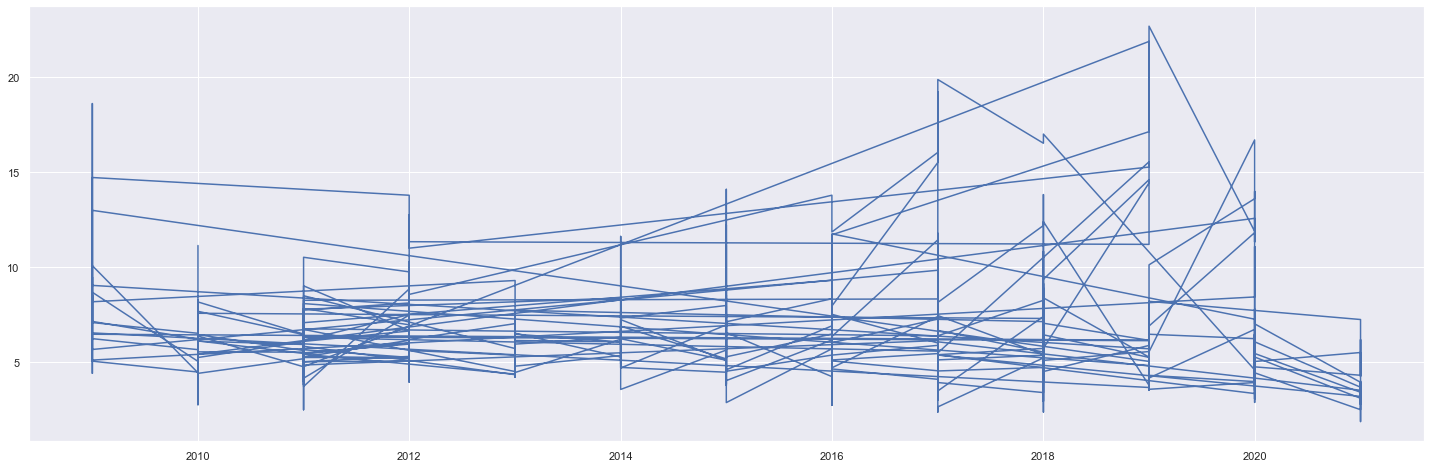

Tosoh


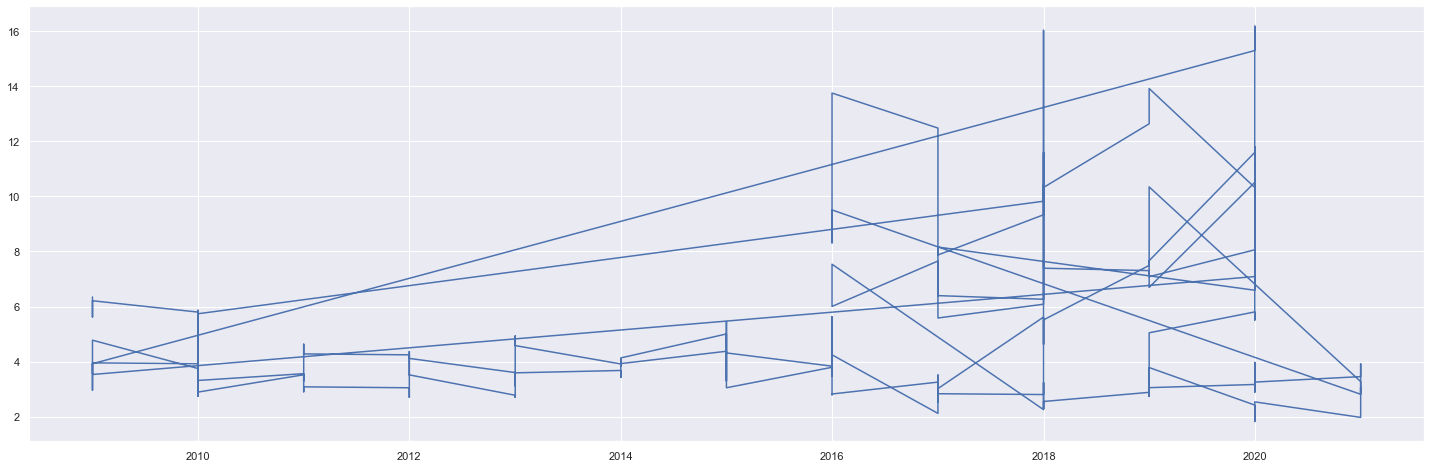

Trinity Biotech


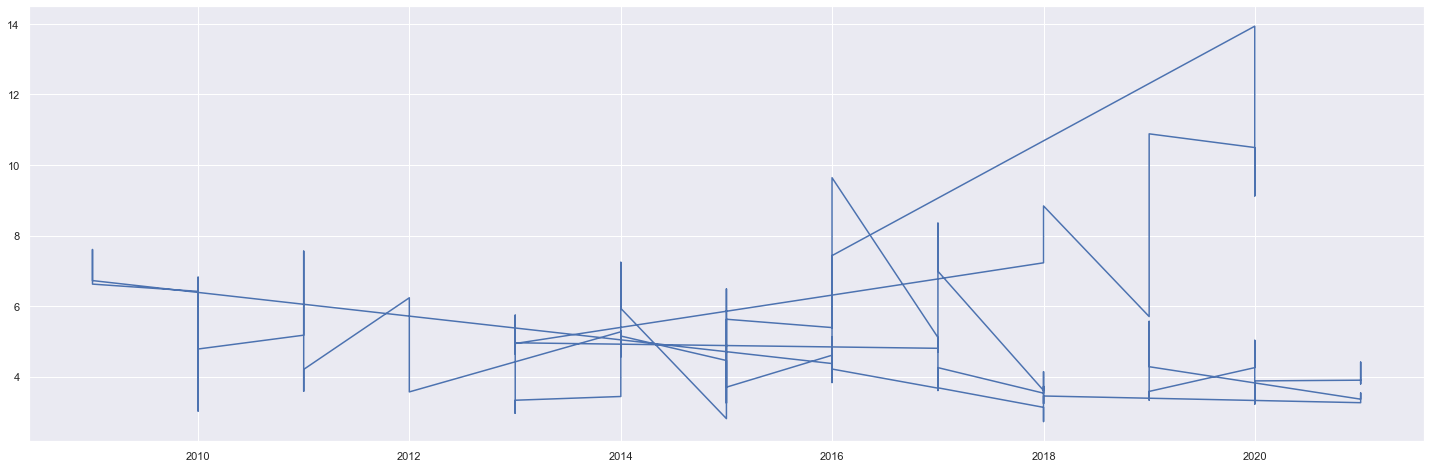

Vitros


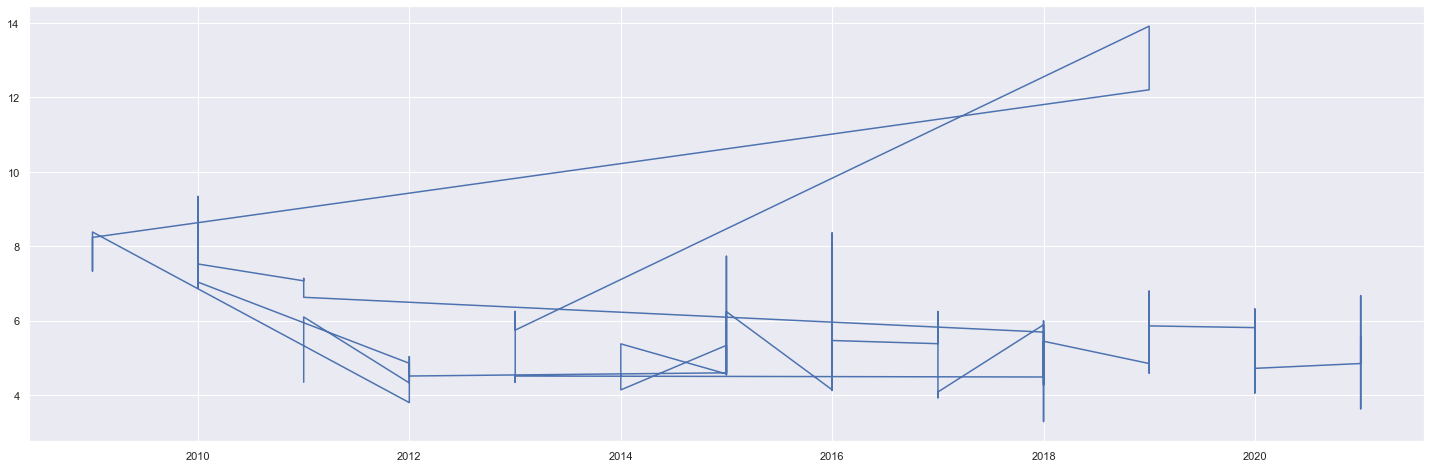

In [25]:
#quick overview of the data
for name, data in manufacturers:
    print(name)
    plt.plot(data.index, data['Total'])
    plt.show()

# Note
Hier is te zien dat er niet een duidelijke lijn wordt weergegeven van een chronologische volgorde van de jaren. Dit is een indicatie dat in de dataset de datapunten nog moeten worden gesorteerd. Bij de volgende grafieken zijn de datapunten gesorteerd.

Abbott


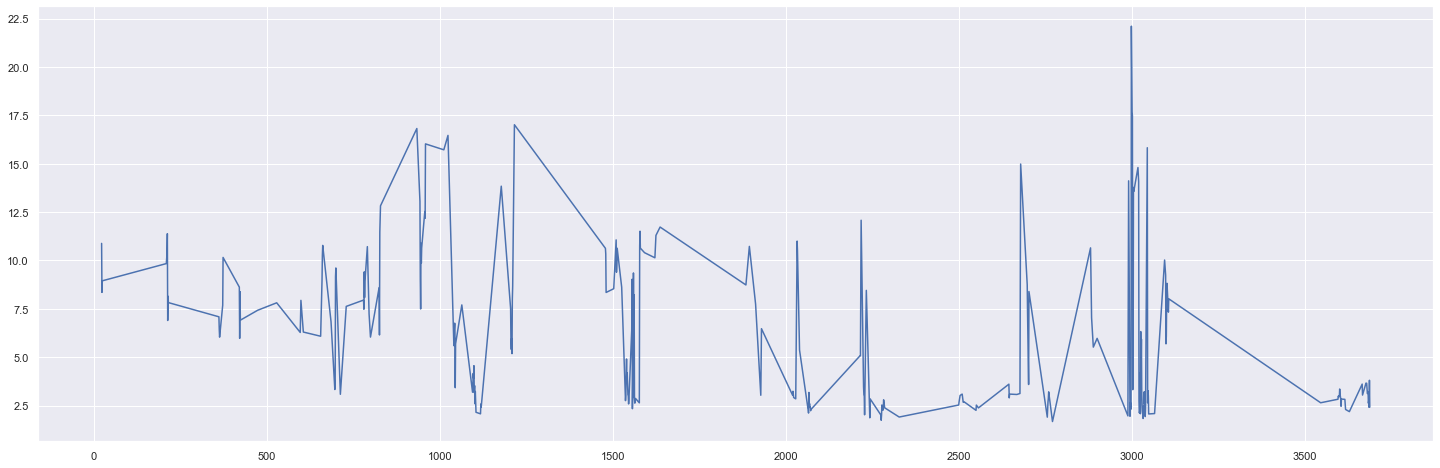

Alere


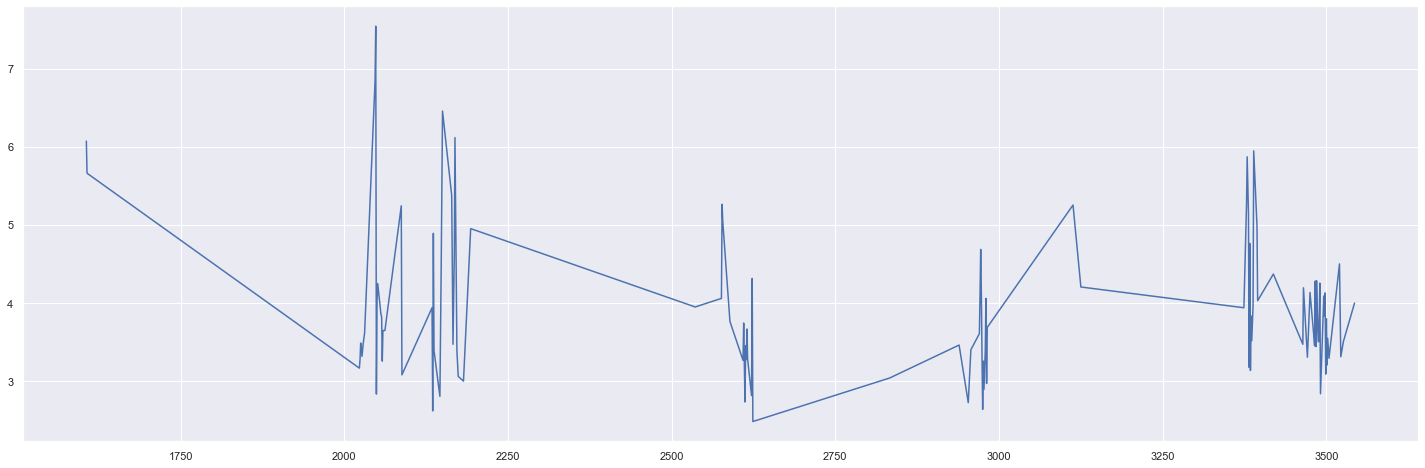

Beckman Coulter


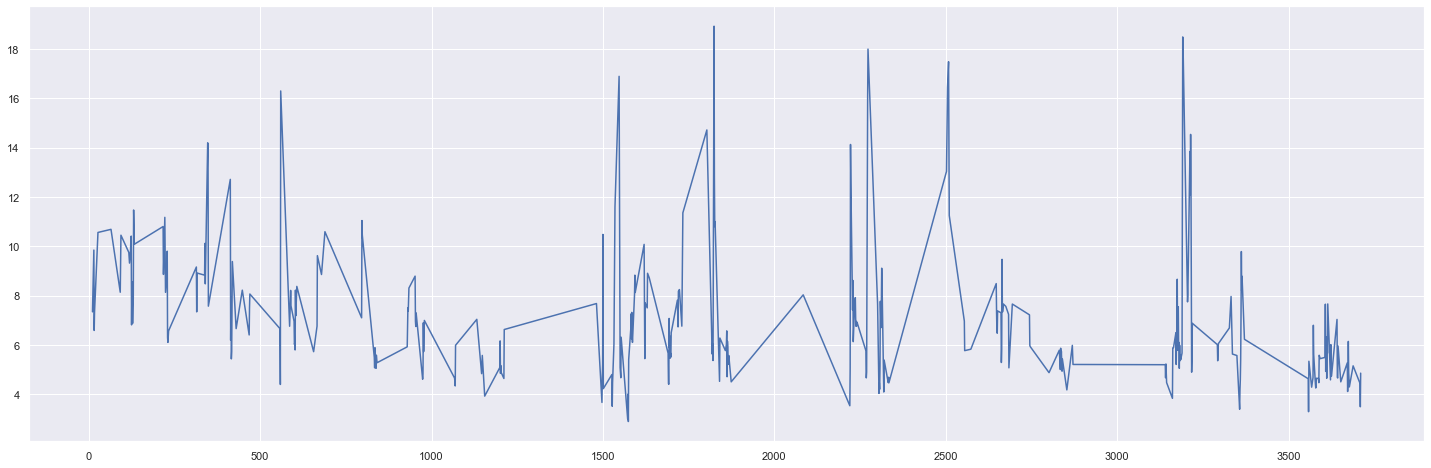

Bio-Rad


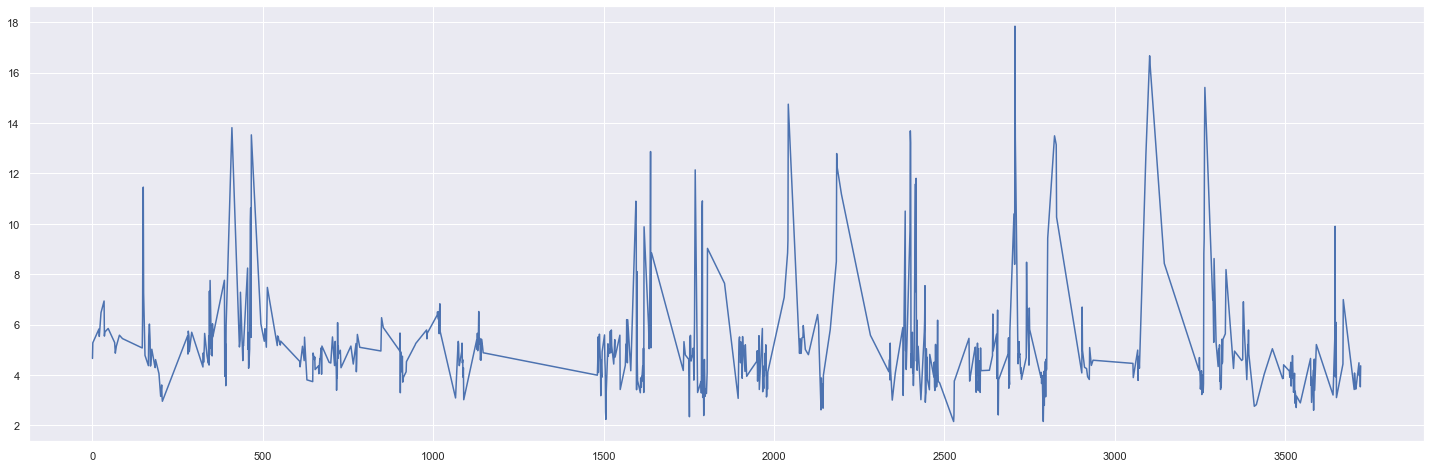

Roche Diagnostics


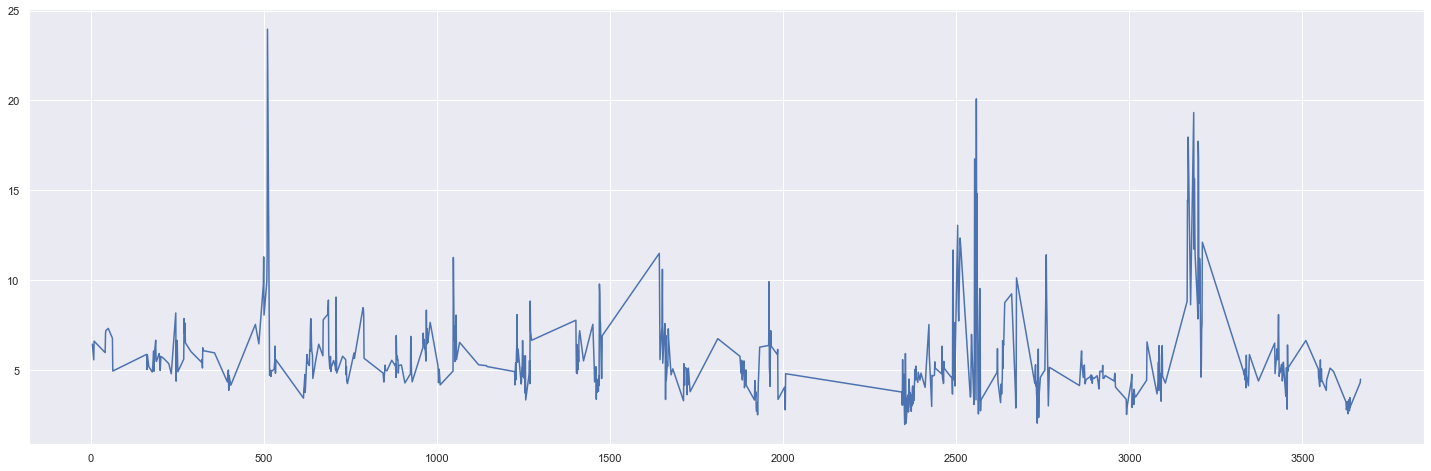

Sebia


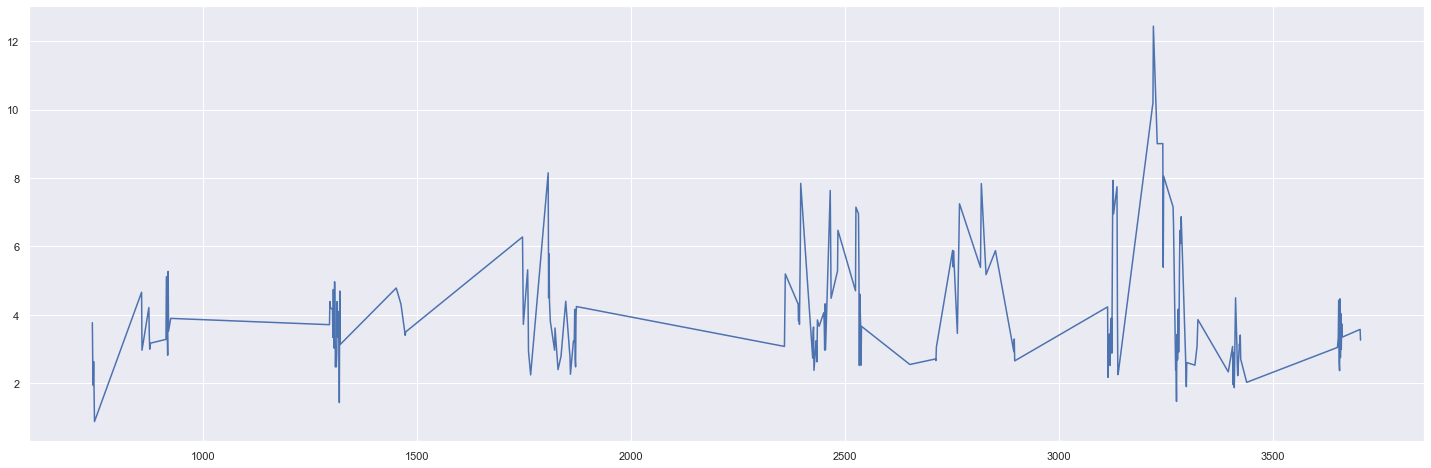

Siemens


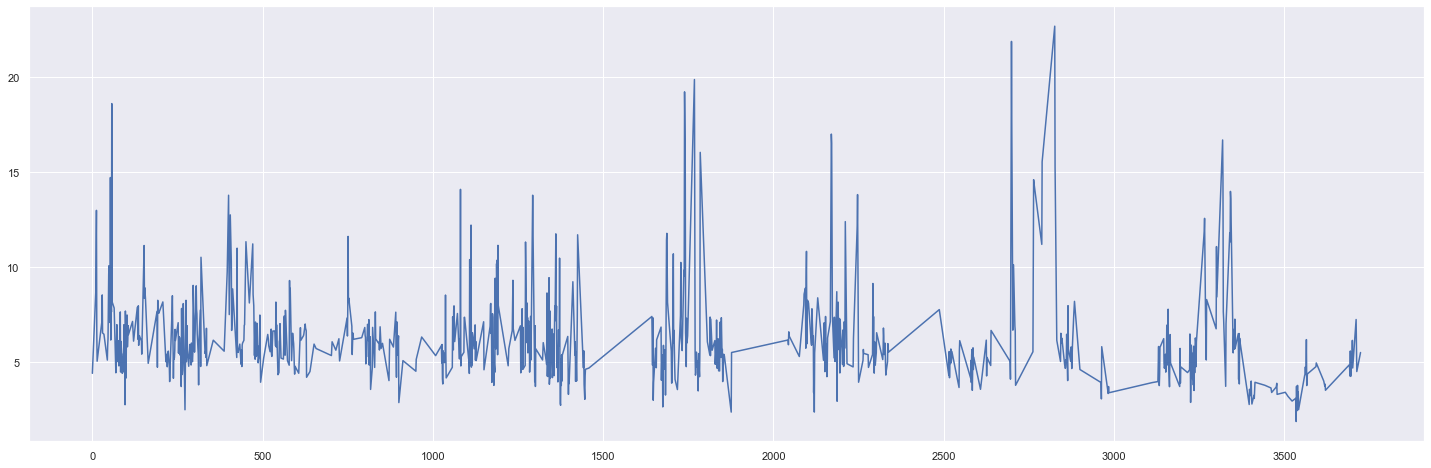

Tosoh


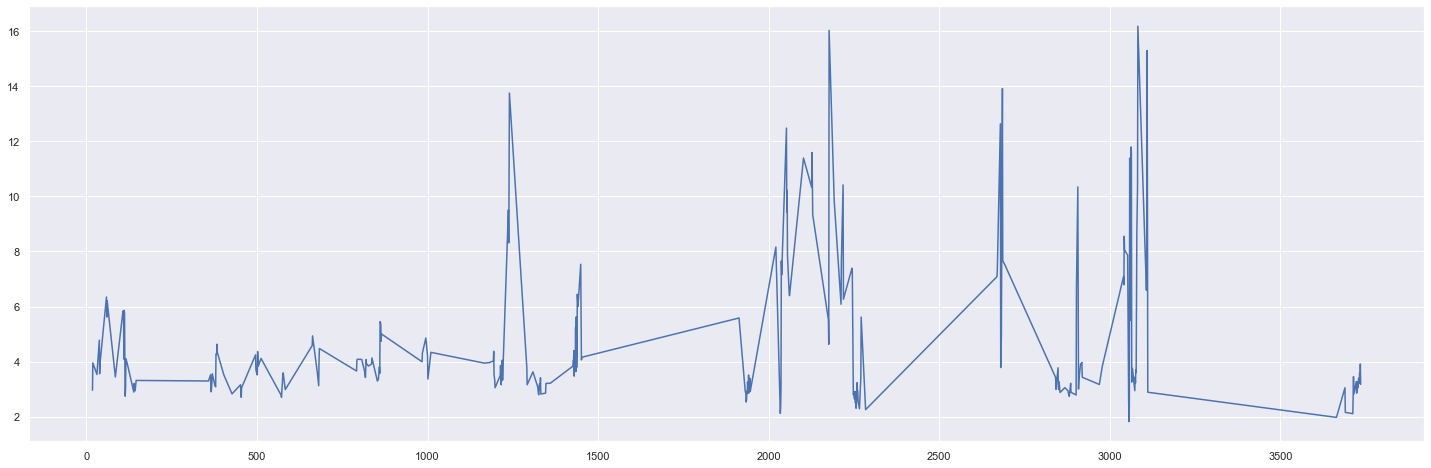

Trinity Biotech


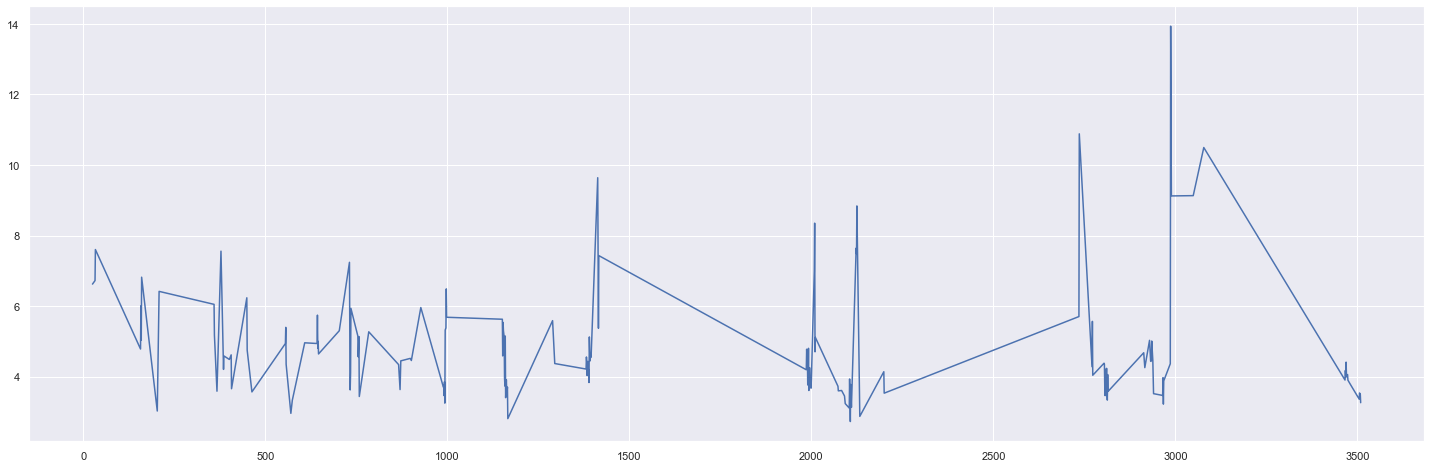

Vitros


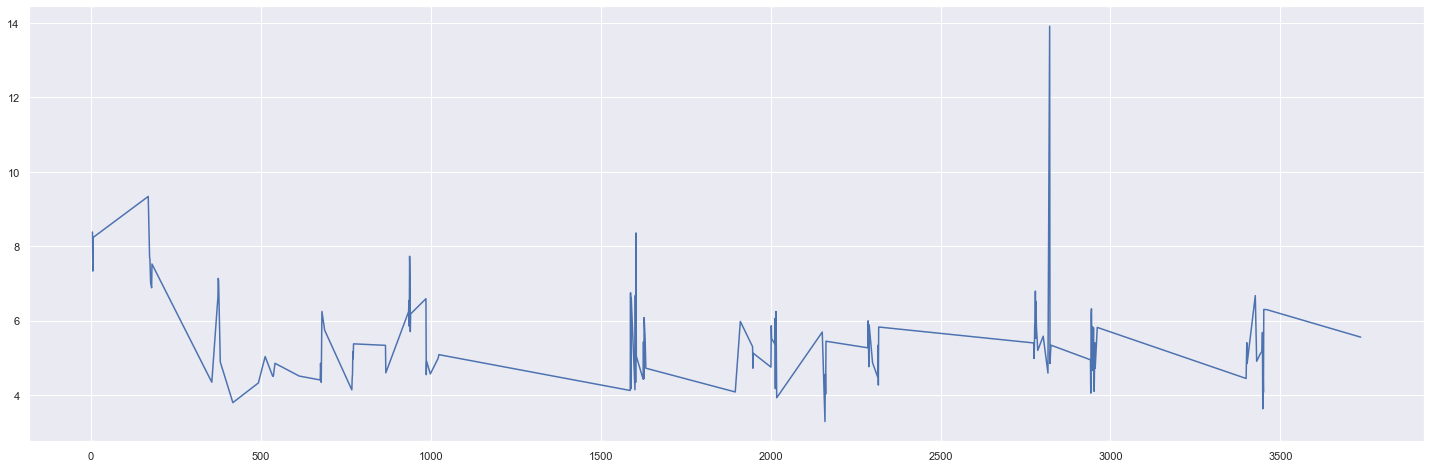

In [26]:
manufacturers_top10 = top10_manufacturers.sort_values(by="Year")
manufacturers_top10 = manufacturers_top10.reset_index()

manufacturers_top10=manufacturers_top10[['Manufacturer', 'Total']]
manufacturers_sorted = manufacturers_top10.groupby("Manufacturer")

for name, data in manufacturers_sorted:
    print(name)
    plt.plot(data.index, data['Total'])
    plt.show()

# Analyse lijnplot
In de gesorteerde grafieken is een redelijke stationaire lijn te zien. Dit zal worden meegenomen in het bepalen van de parameters van het ARIMA model.

# Modeling : parameters ARIMA

In [27]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity.
from statsmodels.tsa.stattools import adfuller
List_meetmethoden = []


#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')    
    
    # data['Total'].plot(figsize=(16,10))
    # plt.show() 
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    
    if df_stationarityTest[1] > 0.05:
        List_meetmethoden.append(name)
    print("\n")

print("Meetmethoden met een p-waarden boven de 0.05:")
List_meetmethoden

Abbott


ADF Statistic: -1.9898120102862134
n_lags: 0.29105796634827763
p-value: 0.29105796634827763
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


Alere


ADF Statistic: -4.340042847938978
n_lags: 0.0003783913537194656
p-value: 0.0003783913537194656
Critial Values:
   1%, -3.49181775886872
Critial Values:
   5%, -2.8884437992971588
Critial Values:
   10%, -2.5811201893779985


Beckman Coulter


ADF Statistic: -3.2663735133490923
n_lags: 0.016450142108014498
p-value: 0.016450142108014498
Critial Values:
   1%, -3.4495033946549123
Critial Values:
   5%, -2.8699787979596136
Critial Values:
   10%, -2.5712658305164955


Bio-Rad


ADF Statistic: -5.086968935872926
n_lags: 1.4889943958397245e-05
p-value: 1.4889943958397245e-05
Critial Values:
   1%, -3.4405132737812596
Critial Values:
   5%, -2.8660244429195725
Critial Values:
   10%, -2.5691581552588447


Roche Diagnostics


ADF Statistic: -2.4792452298597

['Abbott', 'Roche Diagnostics']

### Analyse van p-values
Een p-value van 0.05 of lager, betekent dat je met zekerheid kan zeggen dat er een relatie is. Wanneer de p-value hoger is dan 0.05 betekent het dat er een kans is op een nulhypothese (voorspelling met geen effect of enige relatie).
Om deze meetmethoden onder de 0.05 te krijgen, wordt de p-value gedifferentieerd. 

#### Differentiatie van meetmethoden met p-value > 0.05

In [28]:
#Één keer diffrentiëren
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n" + name) 
        df_stationarityTest = adfuller(data['Total'].diff().dropna(), autolag='AIC')   
        # data['Total'].diff().plot(figsize=(16,10))
        plt.show() 
        
        print("")
        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    

        


Abbott

ADF Statistic: -5.469566816634822
n_lags: 2.4157069378753383e-06
p-value: 2.4157069378753383e-06
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887

Roche Diagnostics

ADF Statistic: -11.397196142263832
n_lags: 7.805836700751158e-21
p-value: 7.805836700751158e-21
Critial Values:
   1%, -3.4414256033746606
Critial Values:
   5%, -2.8664262627821473
Critial Values:
   10%, -2.569372254520843


In [29]:
#2x diff = I (ARIMA)
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n")
        print(name) 
        # data['Total'].diff().diff().plot(figsize=(16,10))
        # plt.show()
        data_diff = data['Total'].diff().diff().dropna()
        
        df_stationarityTest = adfuller(data_diff, autolag='AIC')    

        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    




Abbott
ADF Statistic: -8.002101000544423
n_lags: 2.319181934104945e-12
p-value: 2.319181934104945e-12
Critial Values:
   1%, -3.4556556713934934
Critial Values:
   5%, -2.872678352489859
Critial Values:
   10%, -2.57270548832225


Roche Diagnostics
ADF Statistic: -12.62780788192685
n_lags: 1.5279897917157498e-23
p-value: 1.5279897917157498e-23
Critial Values:
   1%, -3.4415584920942424
Critial Values:
   5%, -2.866484781324317
Critial Values:
   10%, -2.569403436033035



# Conclusie p-waarden
Hier is te zien dat bij twee keer differentiëren, de p-waarden juist groter worden. Voor het ARIMA model nemen we de kleinste p-waarde. Daarom nemen we 0 als parameter bij alle meetmethoden. Dus ARIMA(p=?,d=0,q=?)


# ACF & PACF

### ACF plot

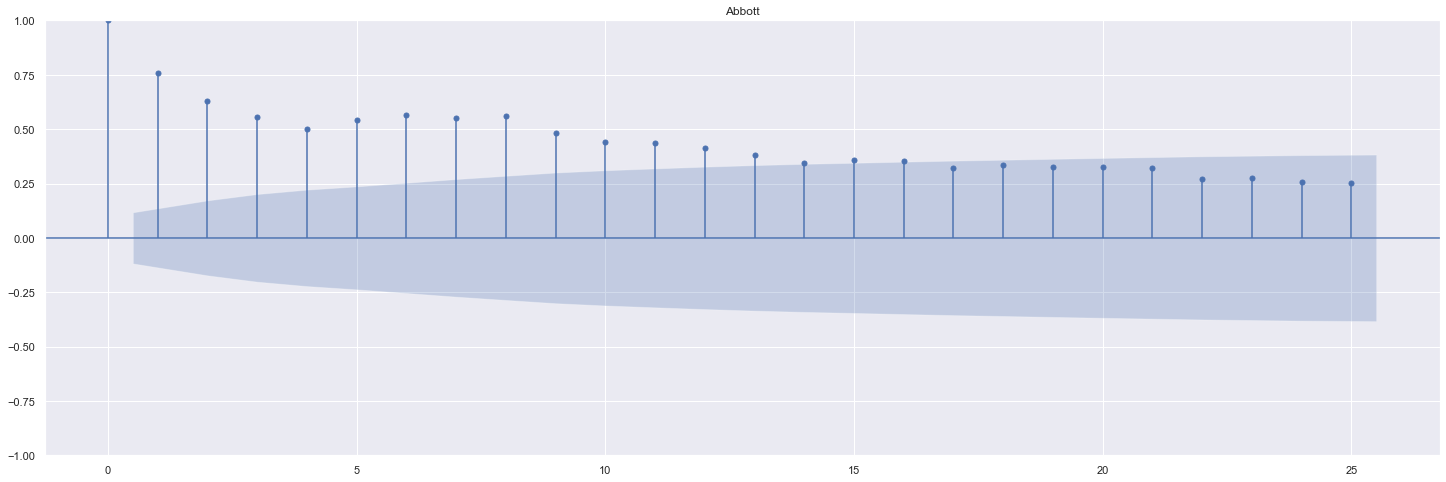

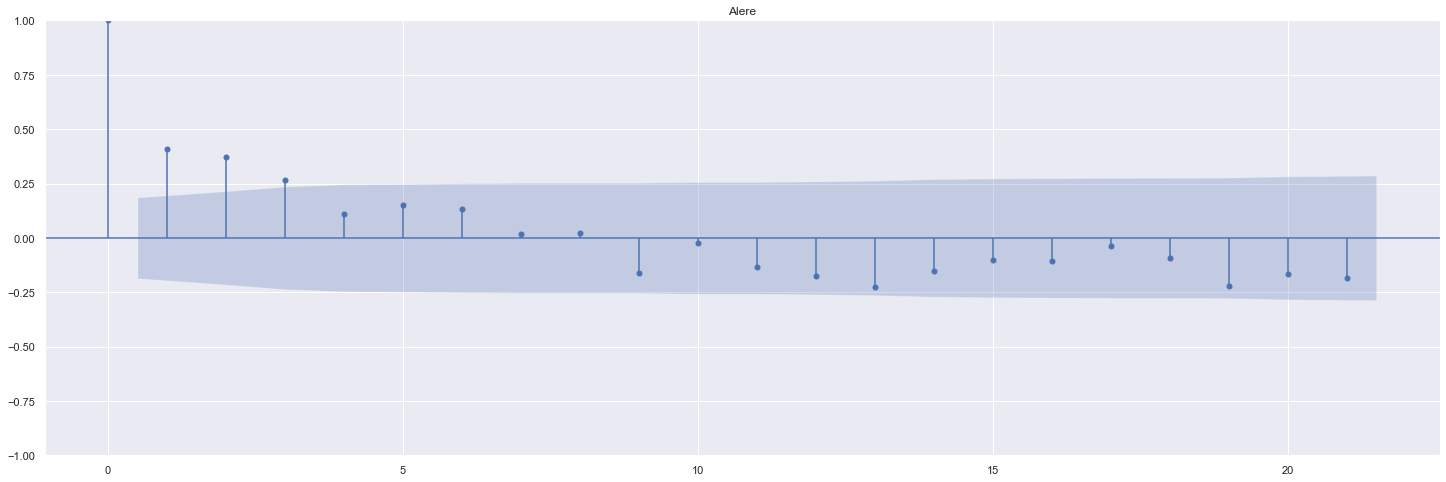

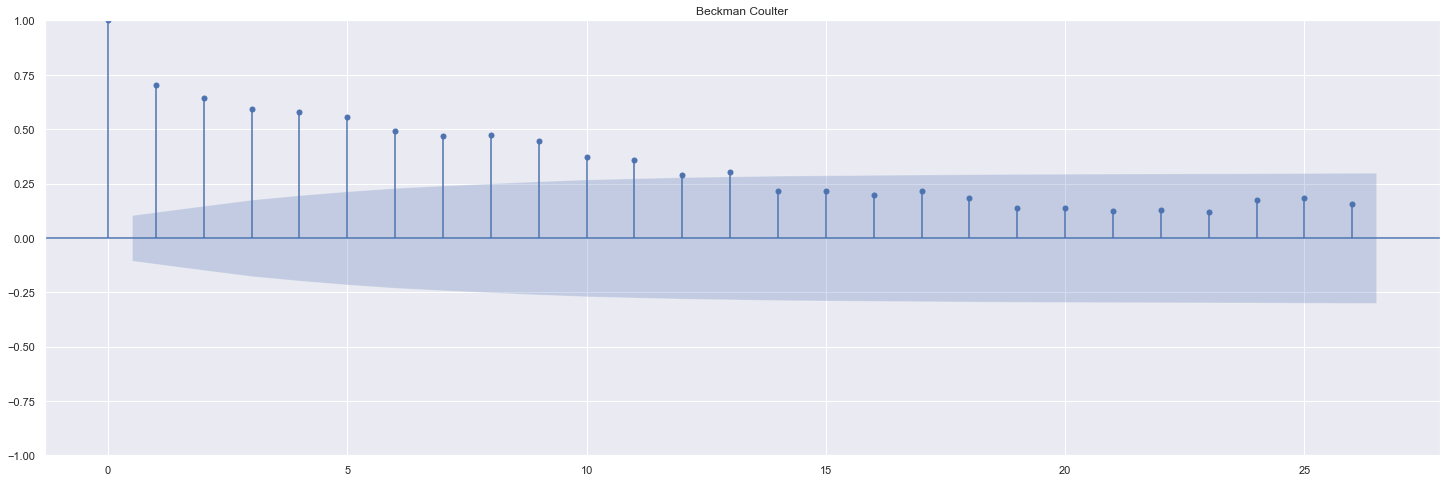

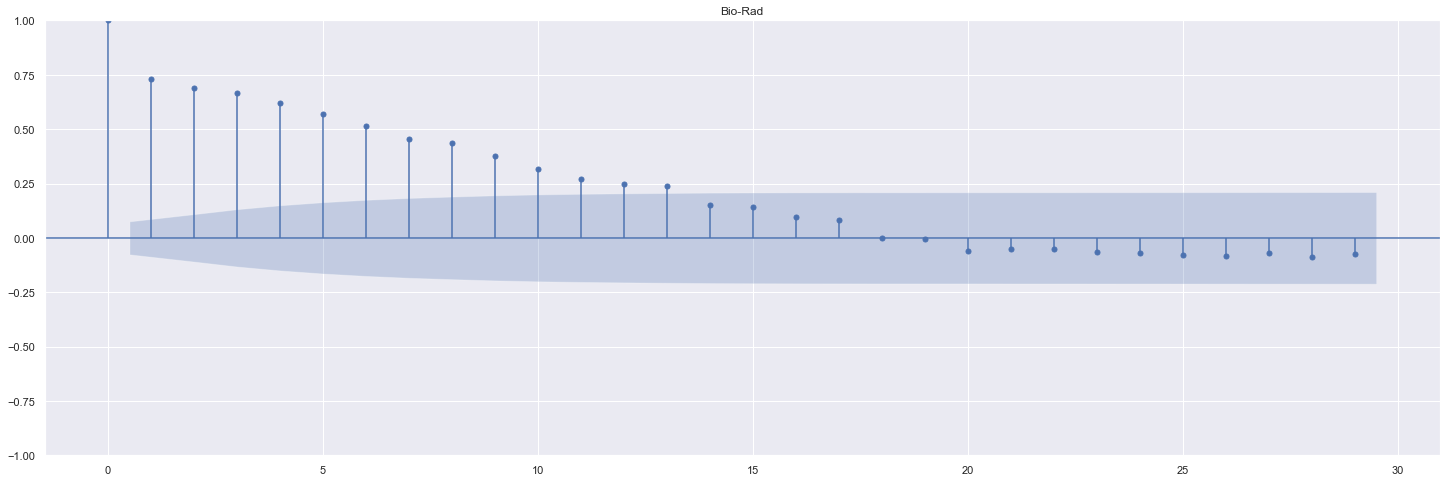

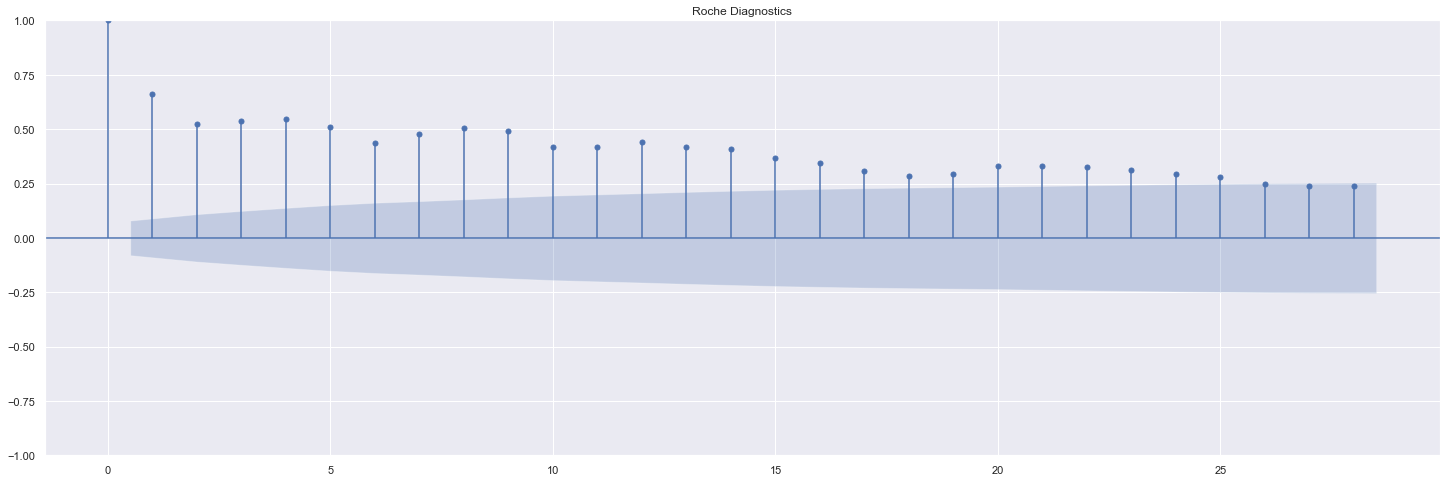

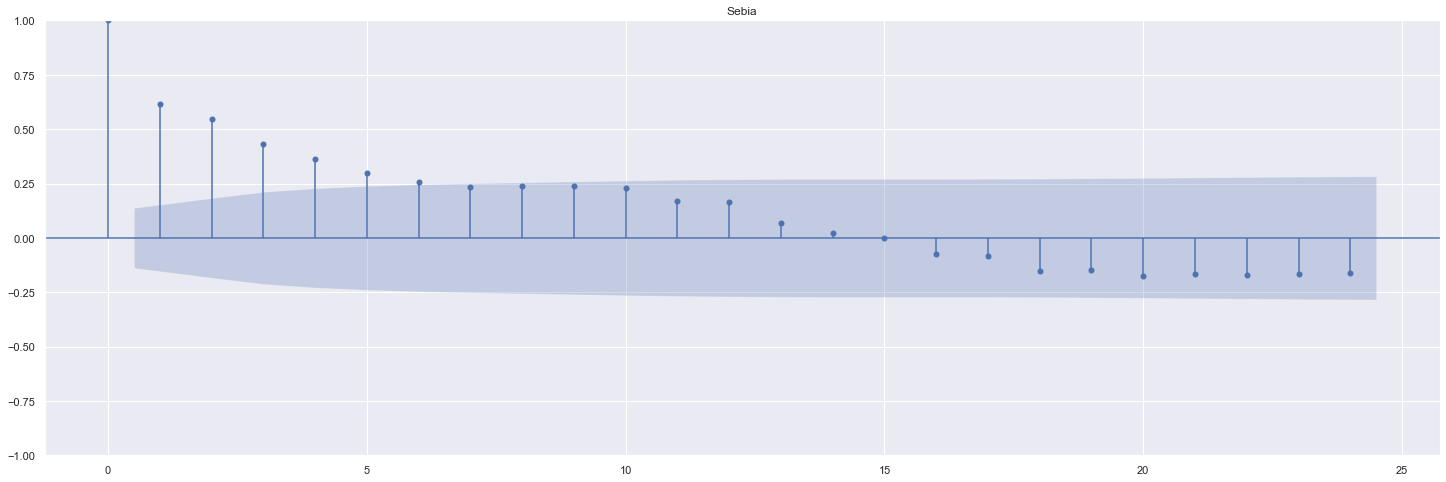

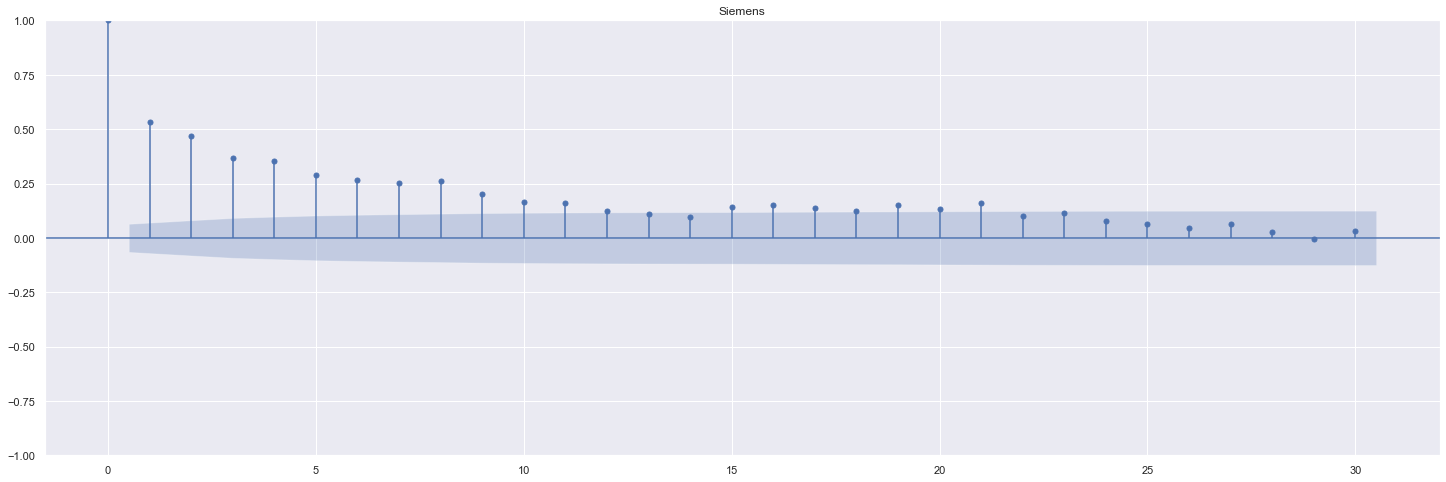

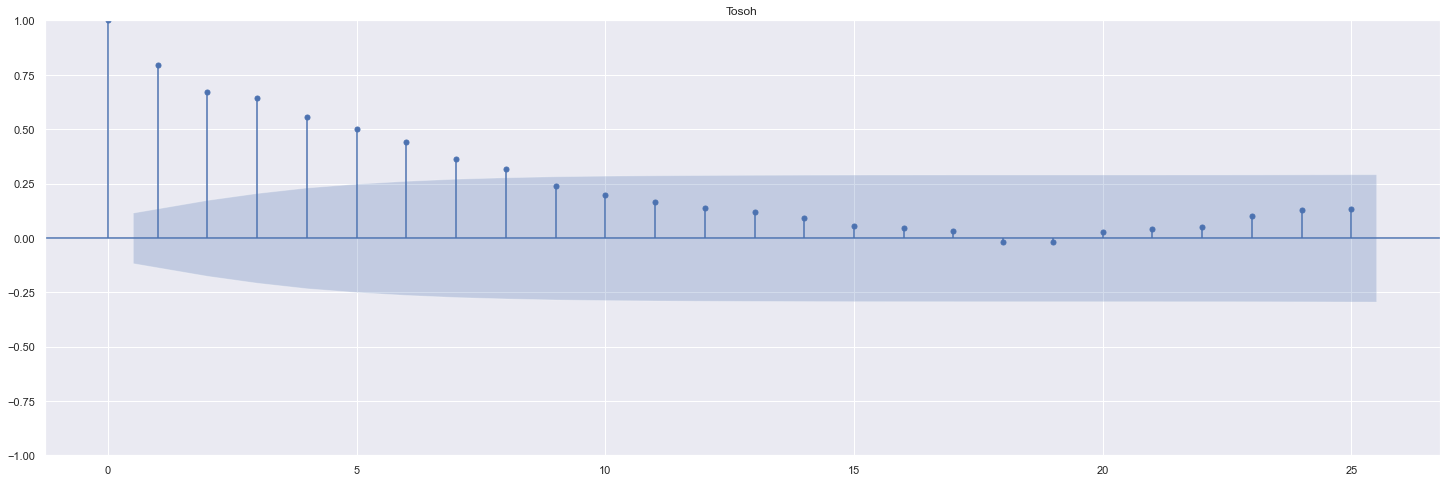

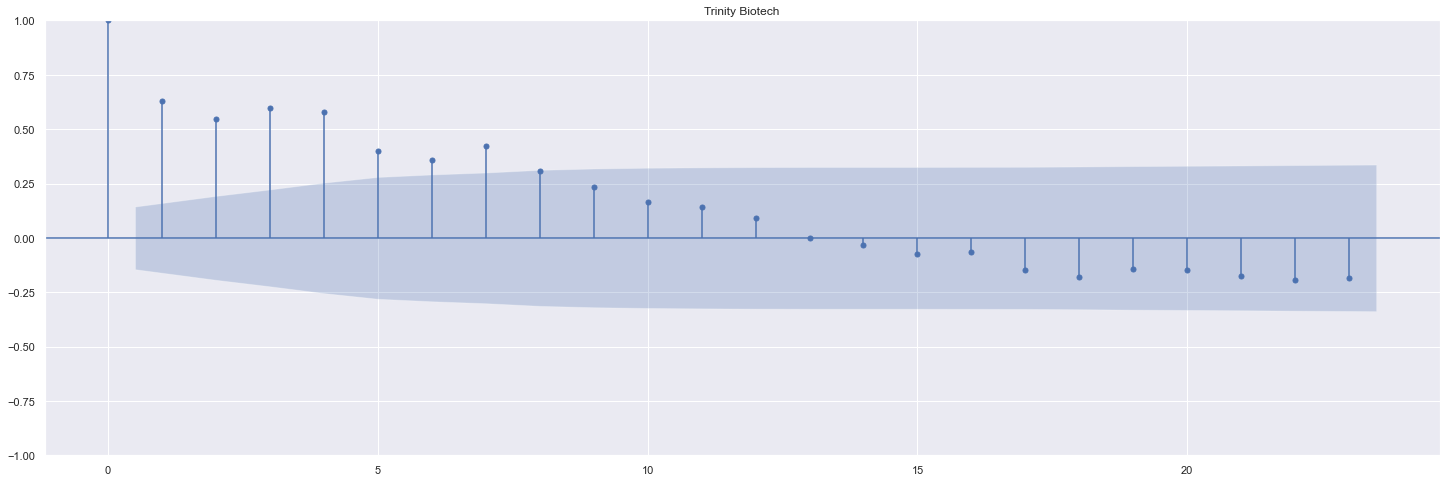

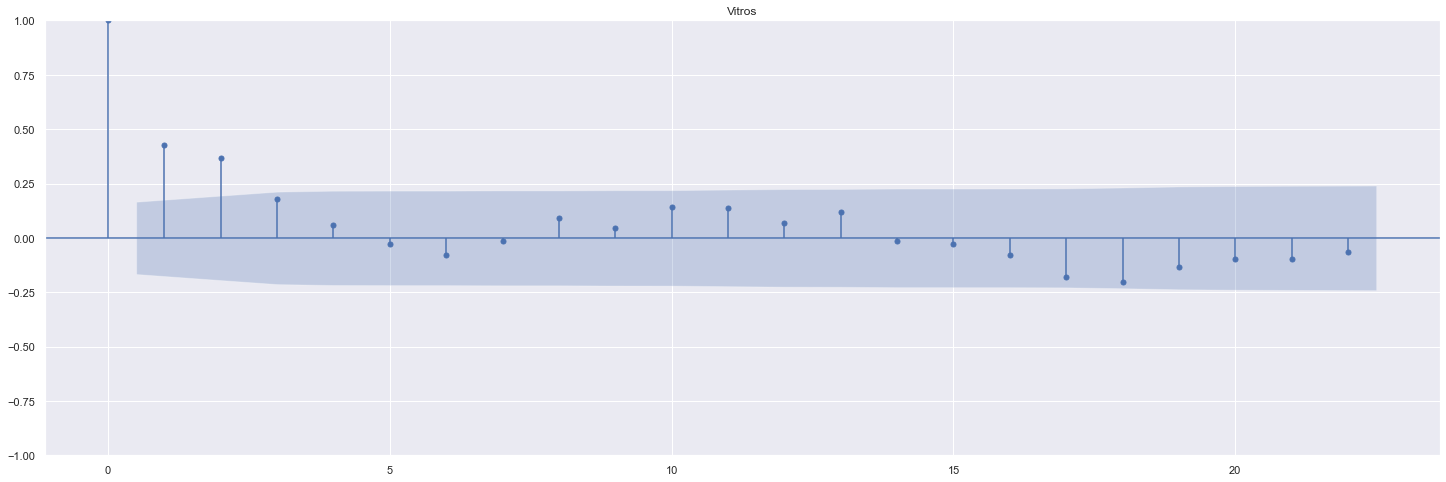

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name, alpha=.05)
    

### Analyse van ACF plot
In deze autocorrelatieplots liggen bijna alle waardes buiten het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan mogelijk ook worden verklaard door ruis). Daarnaast zijn de meeste punten positief. Dit zou betekenen dat we juist wel moeten differentiëren.


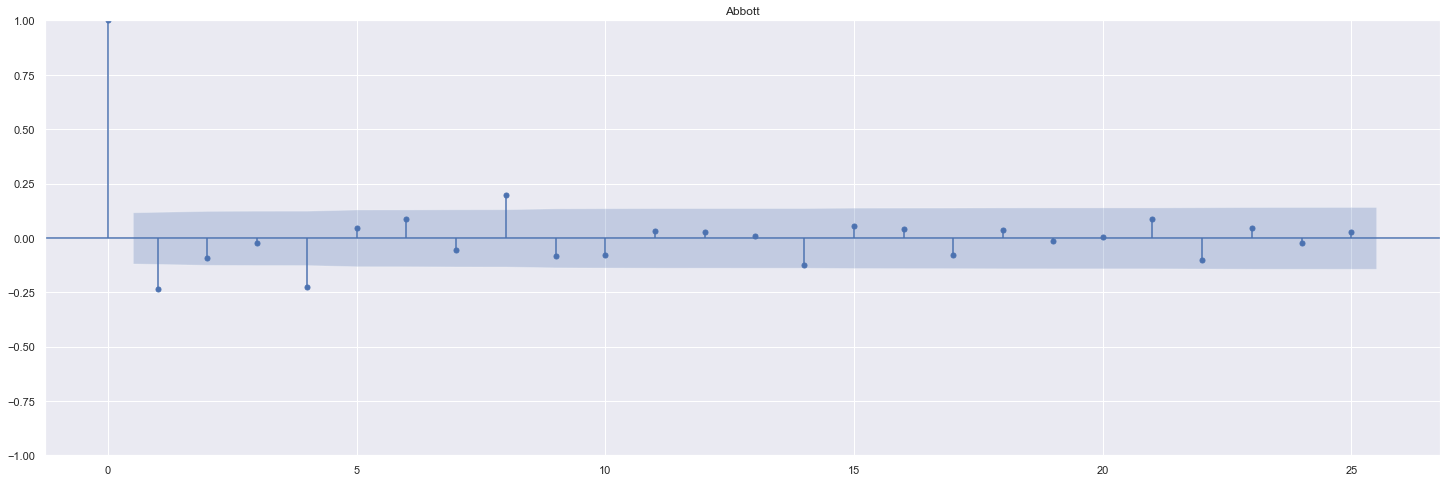

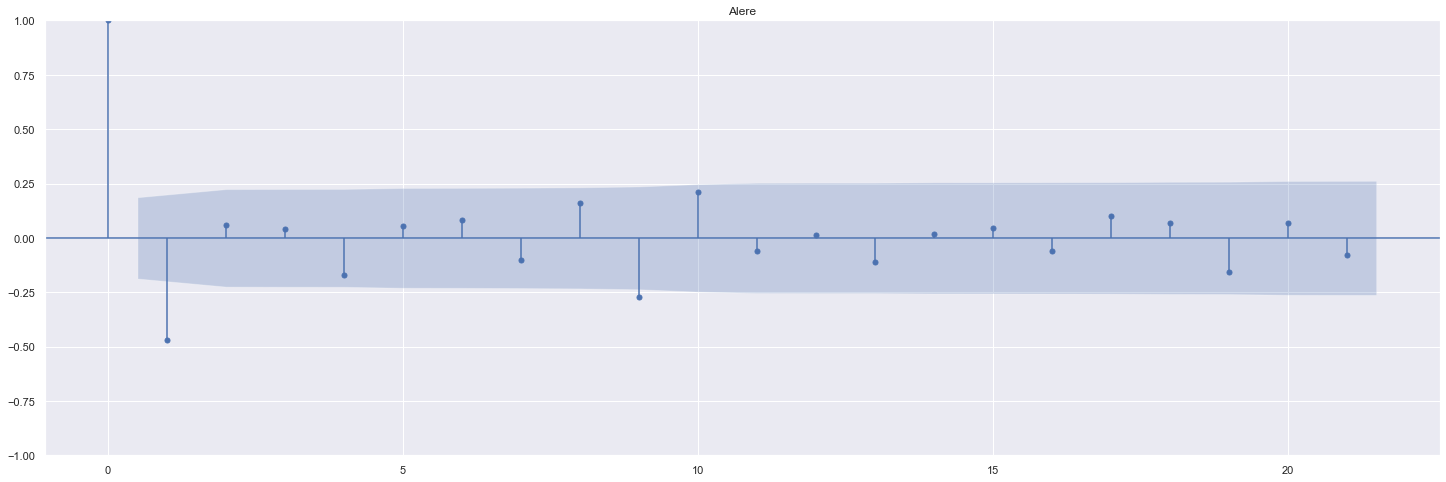

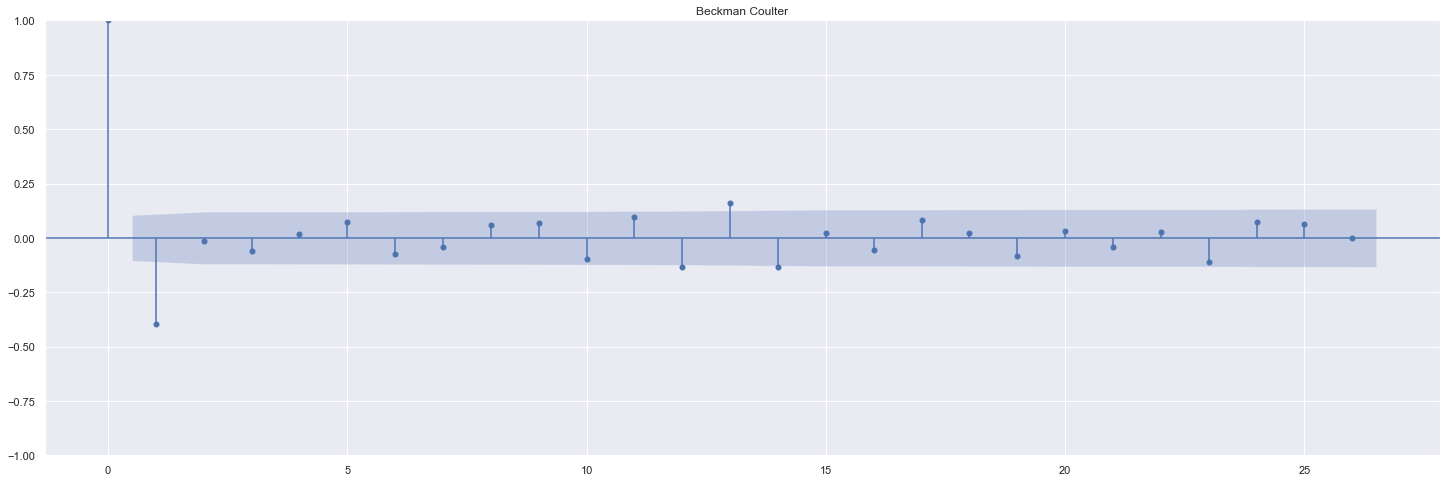

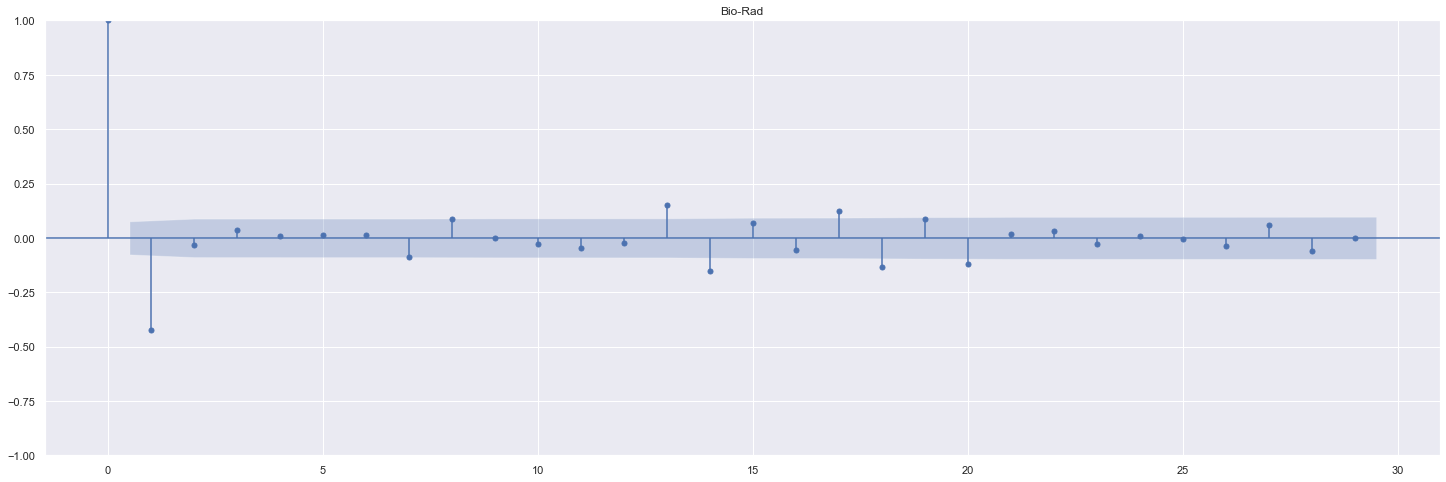

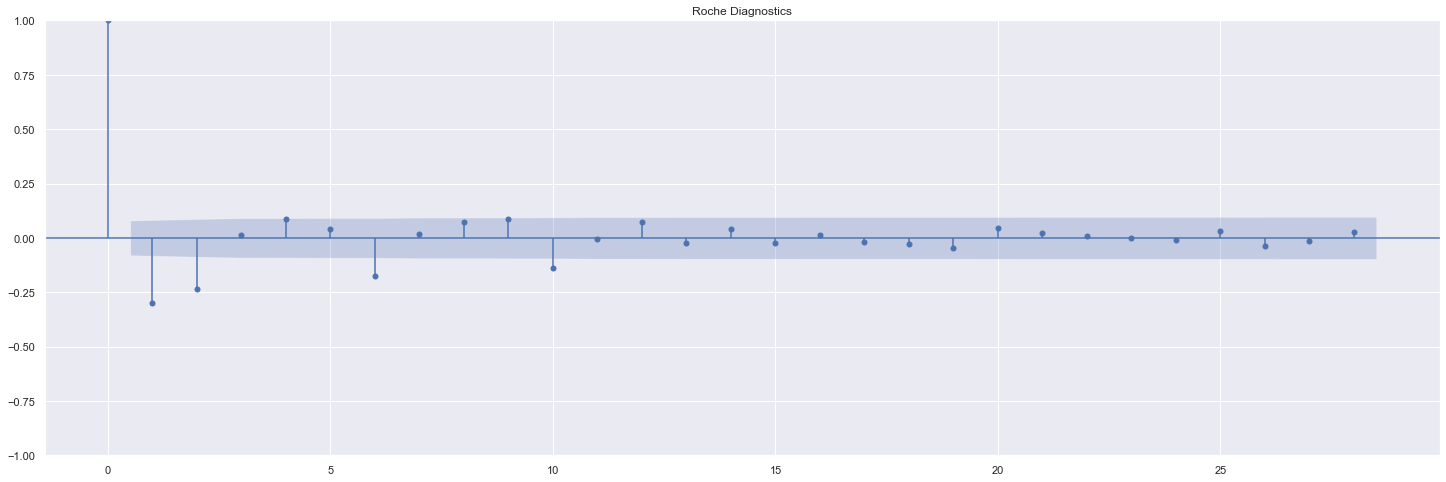

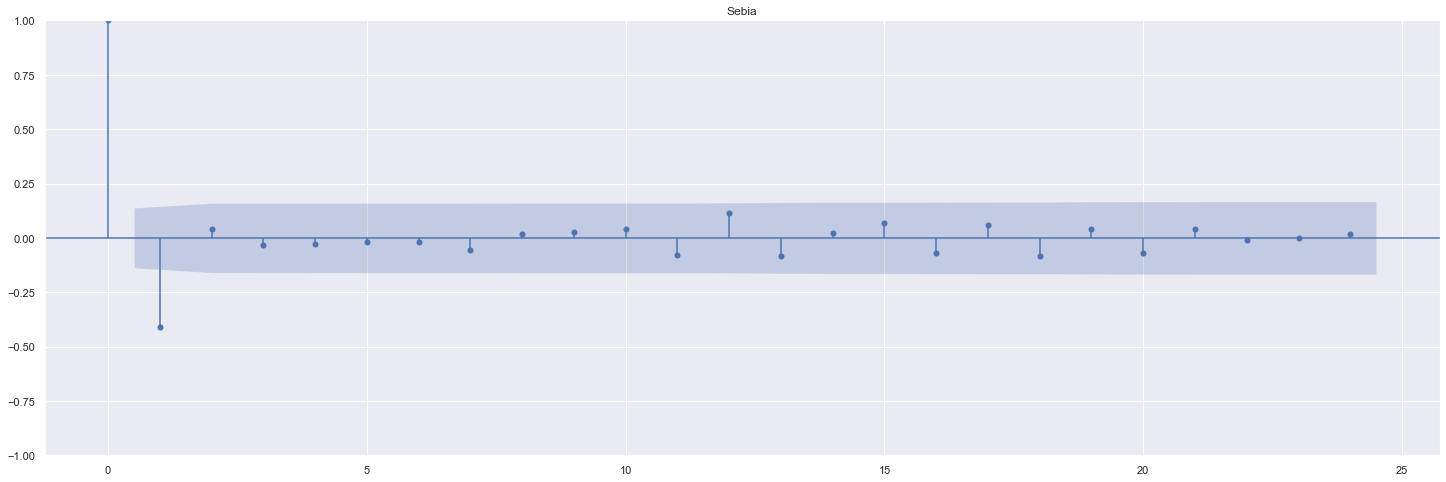

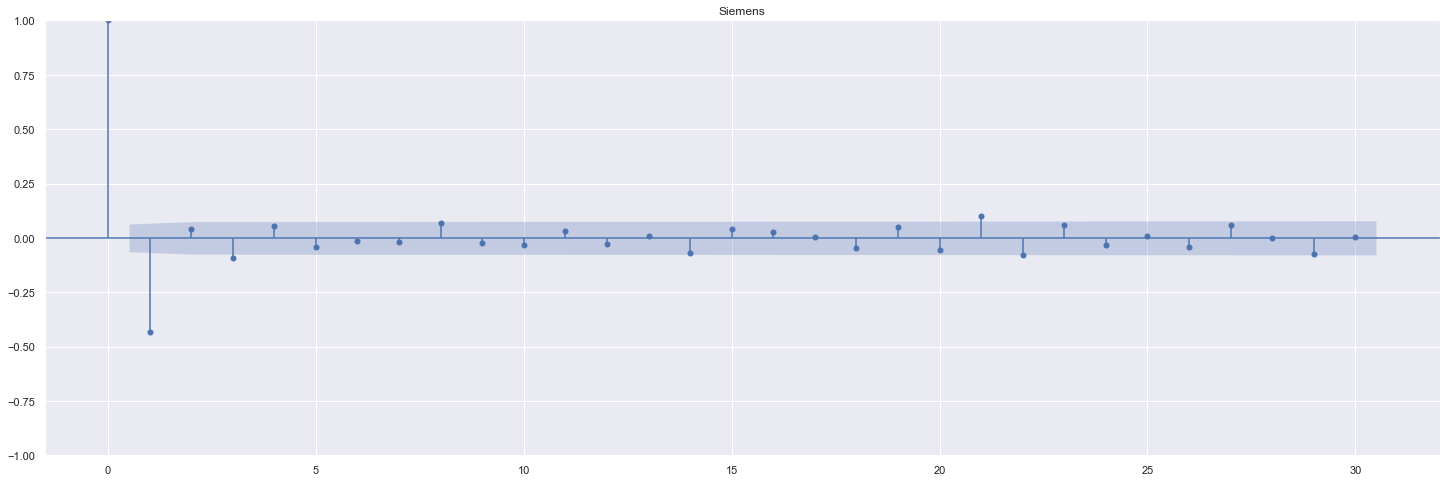

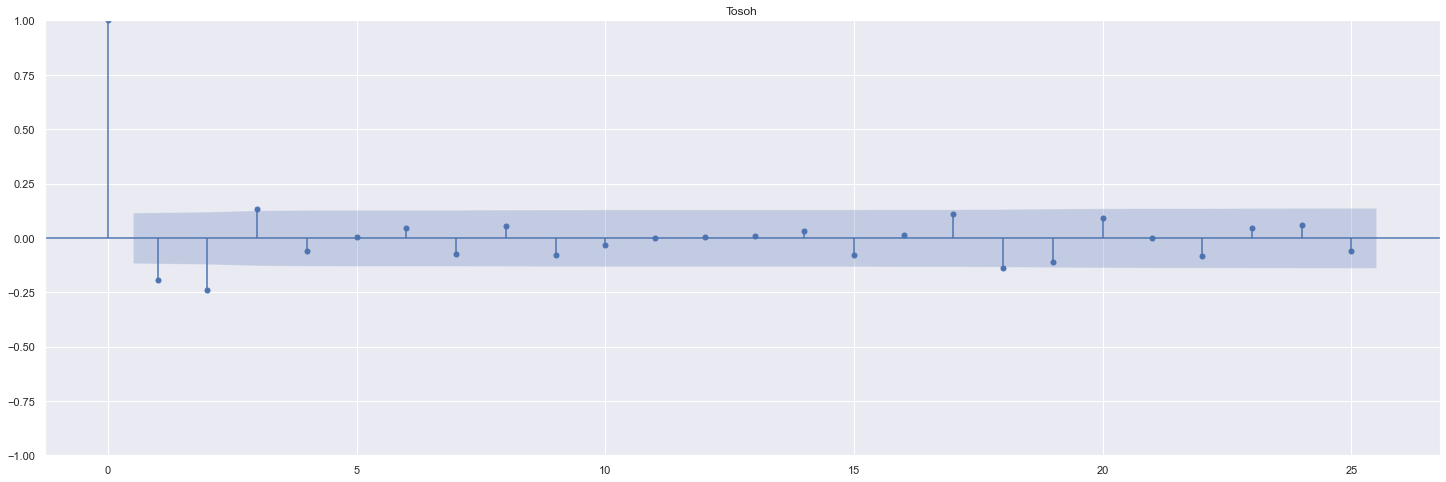

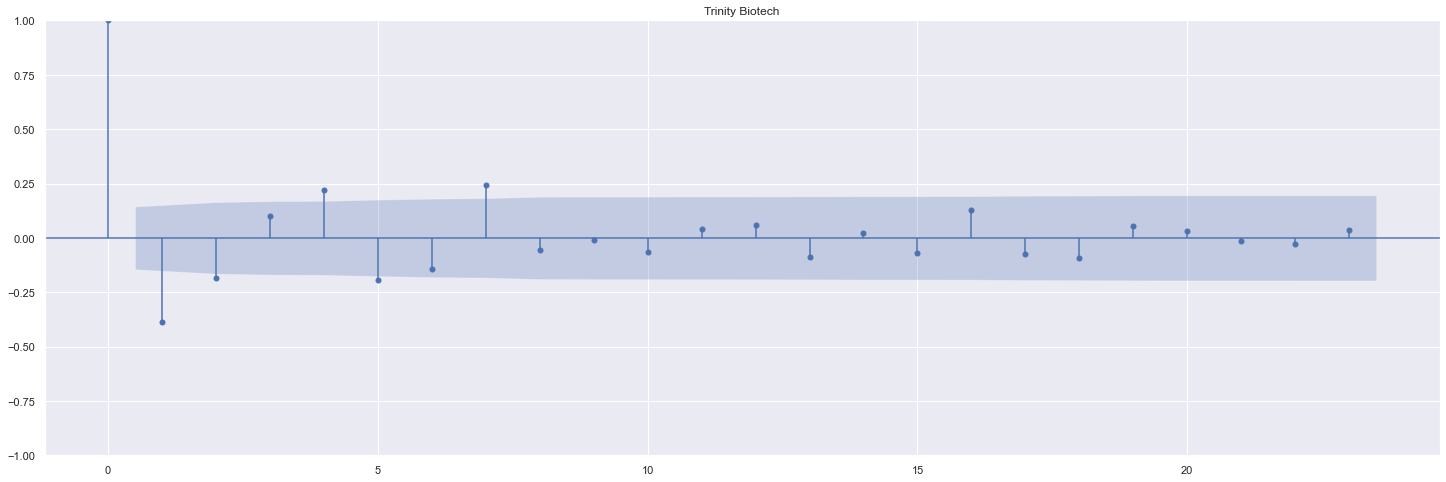

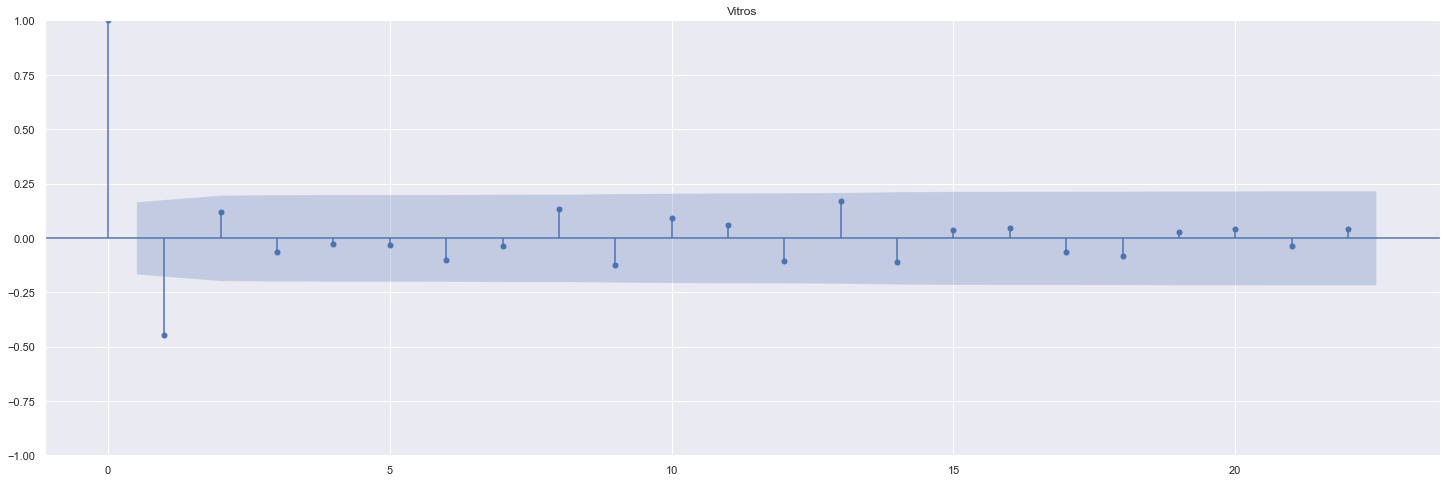

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'].diff().dropna(), title=name, alpha=.05)

# Analayse acf plot met differentiëren
Na het differentiëren ziet de acf plot er gelijk beter uit. Zo is er een verdeling tussen positieve en negatieve waarden ontstaan en vallen de meeste datapunten binnen het onzekerheidsgebied. De Adfuller test en de acf plot laten verschillende uitgangspunten zien. 

Achteraf is hier feedback over gevraagd aan Ruben. Hieruit is gebleken dat de resultaten van de Adfullter test als uitgangspunt zullen worden genomen.
D is 0, dus ARIMA(p=?,d=0,q=?).

Voor het bepalen van de q parameter kijken we naar de datapunten die buiten het onzekerheidsgebied vallen in de acf plot. 
De volgende parameter lijst 'Lijst_MA' is daarvan het resultaat.

In [32]:
Lijst_MA = [10,2,10,9,16,4,8,6,5,2]

# Pacf plot

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.w

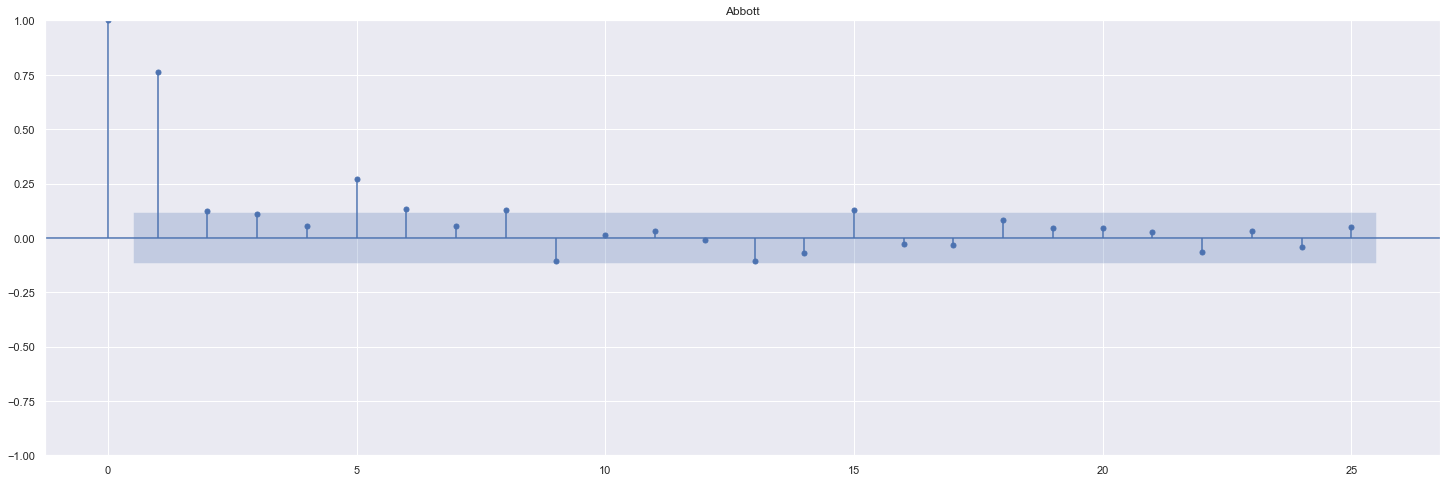

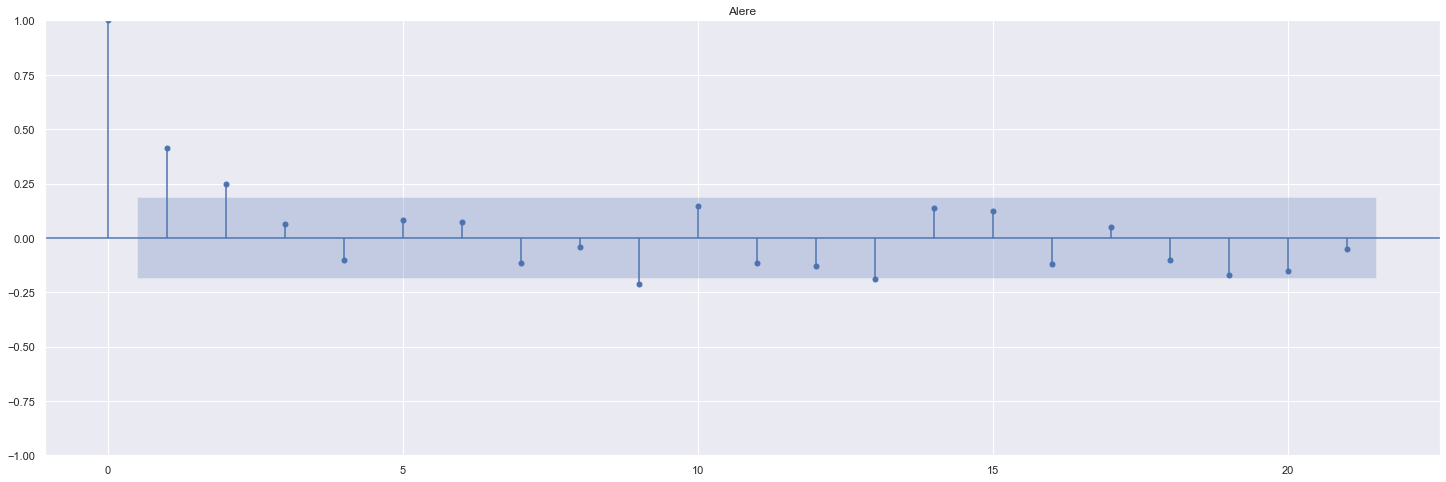

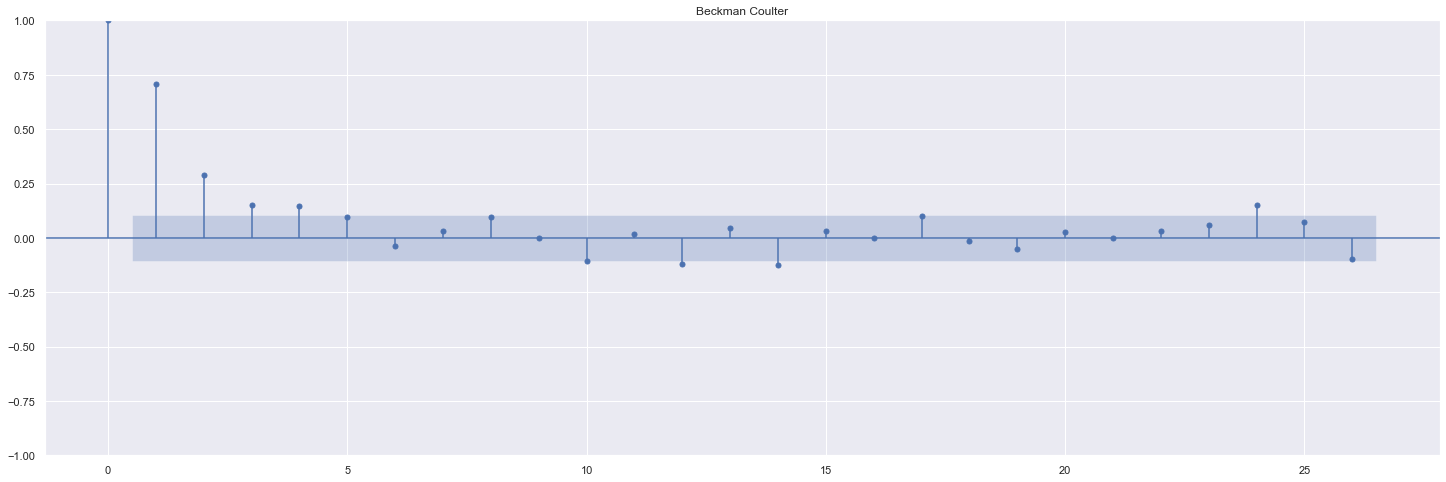

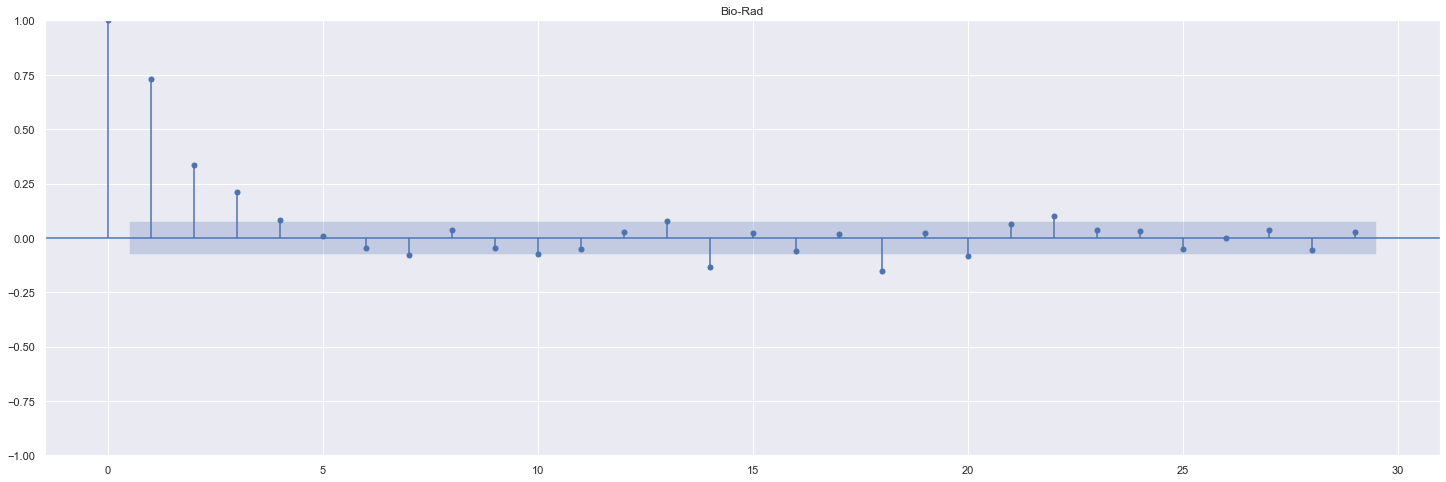

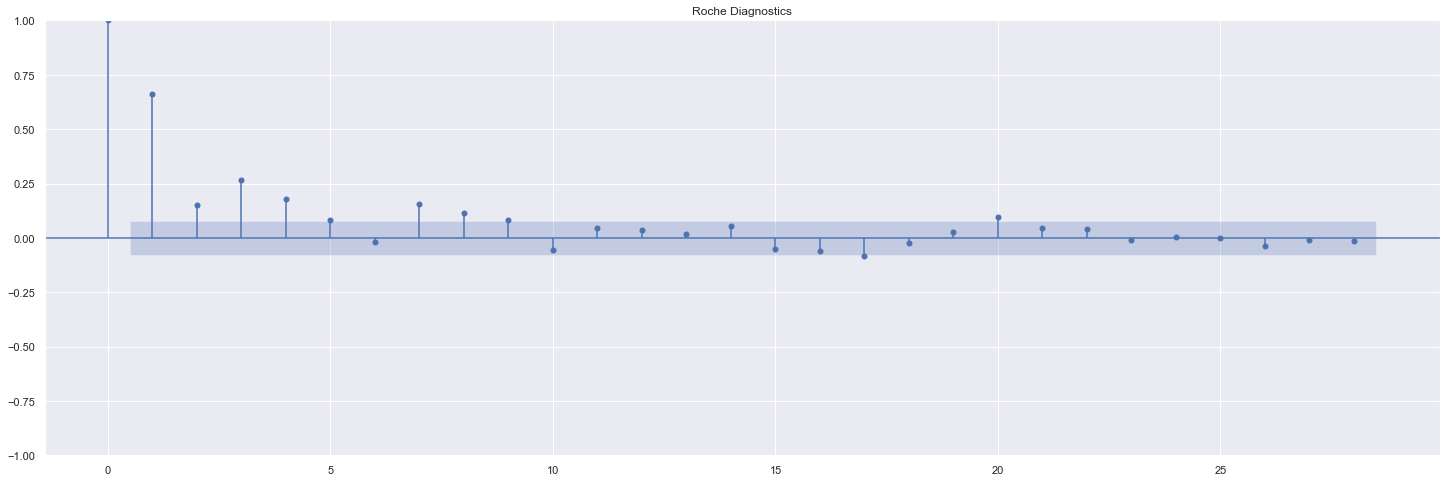

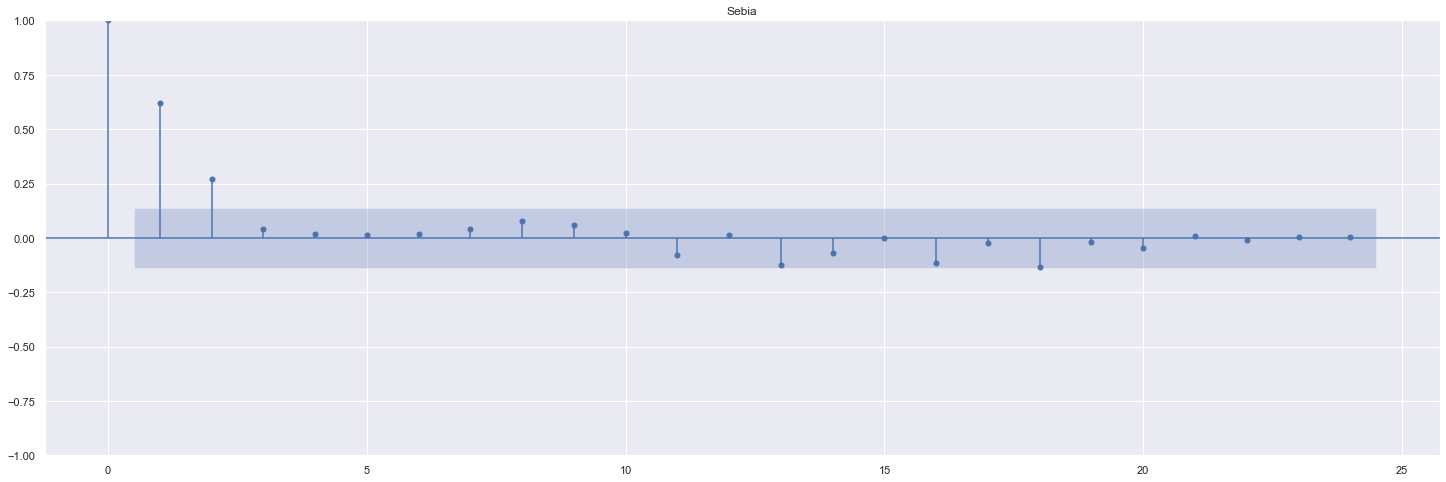

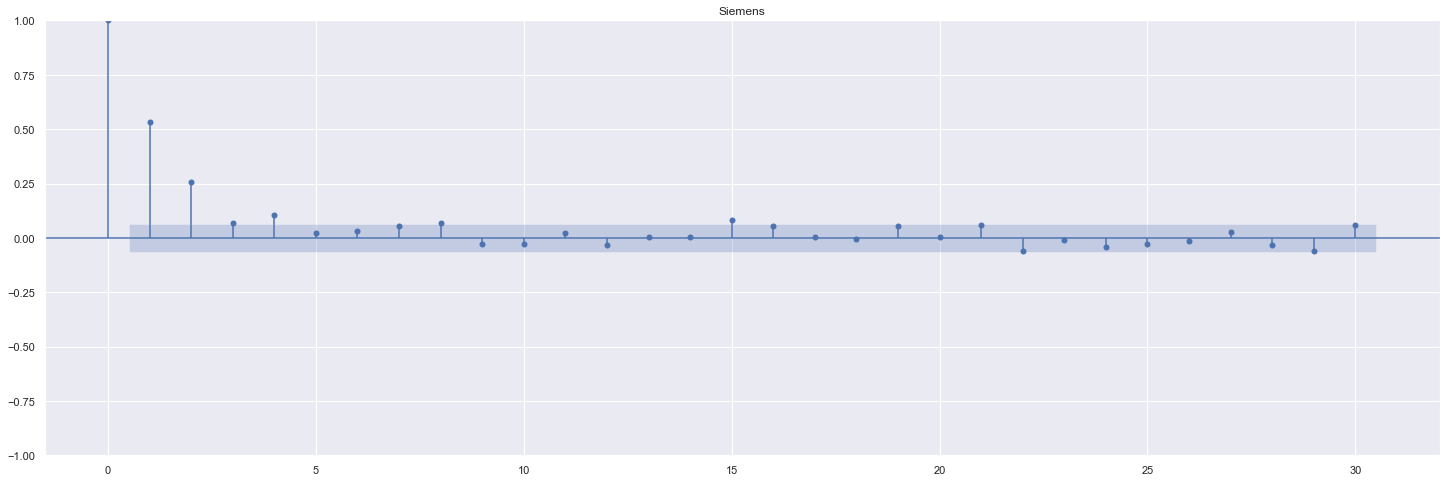

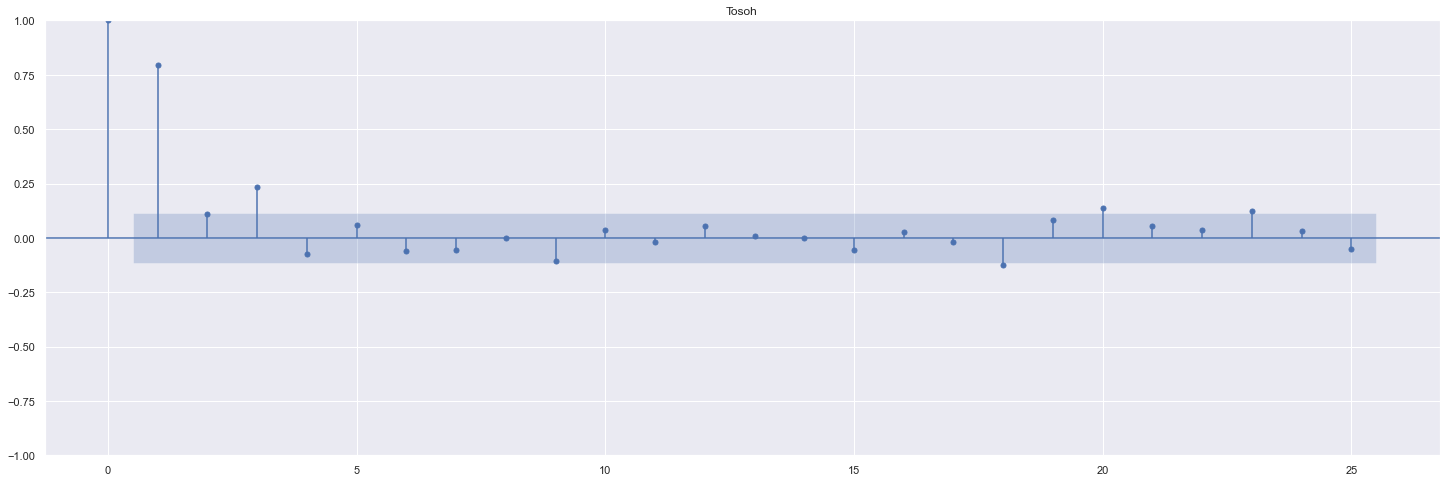

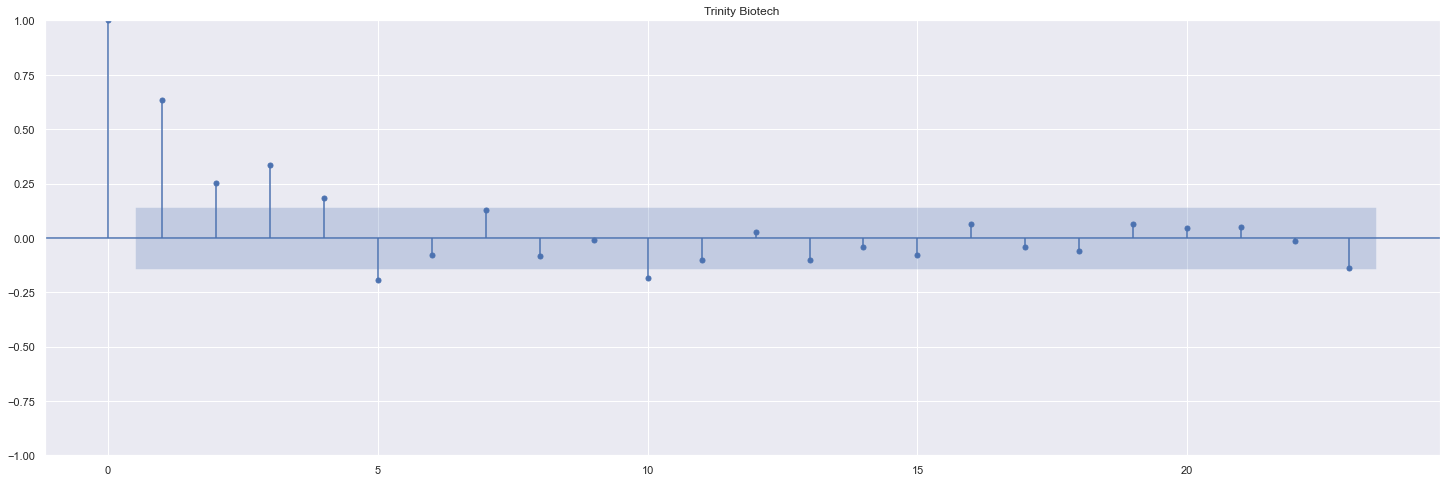

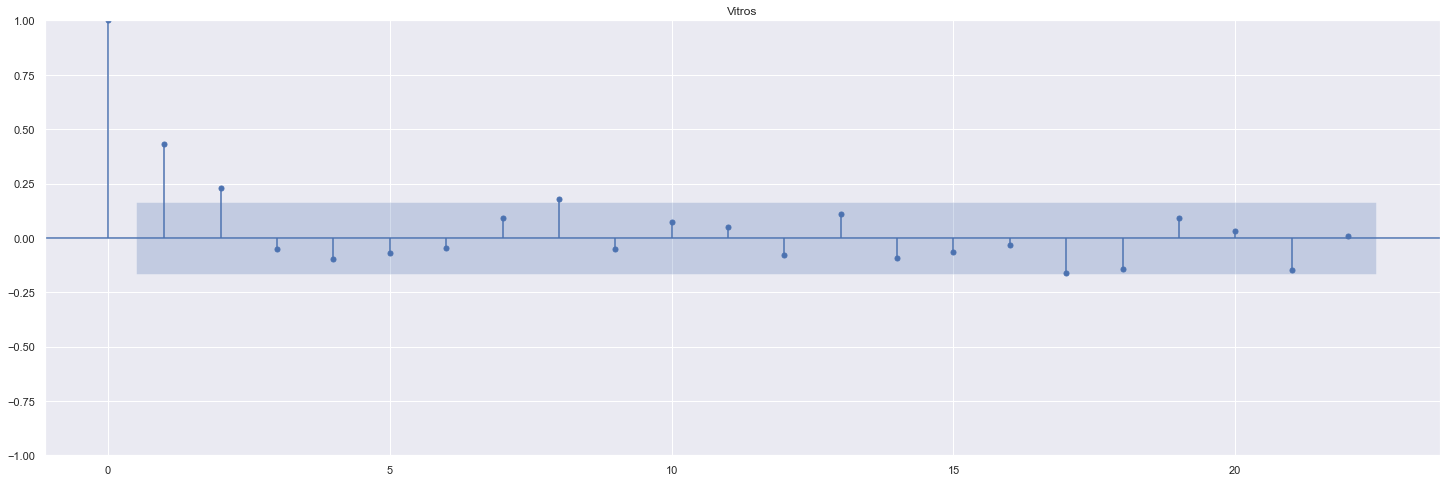

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat, is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=0,q=lijst_MA)

# ARIMA modeling

In [34]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import datetime

## ARIMA summary output

In [35]:
counter= 0

for name, data in manufacturers:
    print(name)
    data.index = pd.DatetimeIndex(data.index).to_period('M')

    model = sm.tsa.arima.ARIMA(data['Total'].diff().dropna(), order=(1,0,Lijst_MA[counter]))
    model_fit = model.fit()
    print(model_fit.summary())
    counter = counter +1
    
   

Abbott


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  277
Model:                ARIMA(1, 0, 10)   Log Likelihood                -630.211
Date:                Fri, 03 Jun 2022   AIC                           1286.422
Time:                        20:53:01   BIC                           1333.534
Sample:                             0   HQIC                          1305.325
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.047      0.138      0.890      -0.086       0.099
ar.L1         -0.6192      0.114     -5.451      0.000      -0.842      -0.397
ma.L1          0.2692      0.112      2.409      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  110
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -138.141
Date:                Fri, 03 Jun 2022   AIC                            286.283
Time:                        20:53:01   BIC                            299.785
Sample:                             0   HQIC                           291.760
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.007     -0.046      0.963      -0.015       0.014
ar.L1          0.7915      0.175      4.514      0.000       0.448       1.135
ma.L1         -1.4518     11.422     -0.127      0.8

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  666
Model:                 ARIMA(1, 0, 9)   Log Likelihood               -1139.955
Date:                Fri, 03 Jun 2022   AIC                           2303.911
Time:                        20:53:04   BIC                           2357.926
Sample:                             0   HQIC                          2324.839
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.003     -0.428      0.668      -0.006       0.004
ar.L1          0.7414      0.062     11.879      0.000       0.619       0.864
ma.L1         -1.3267      0.072    -18.422      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  200
Model:                 ARIMA(1, 0, 4)   Log Likelihood                -340.159
Date:                Fri, 03 Jun 2022   AIC                            694.318
Time:                        20:53:08   BIC                            717.406
Sample:                             0   HQIC                           703.661
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0177      0.027      0.664      0.507      -0.034       0.070
ar.L1          0.5710      0.426      1.339      0.181      -0.265       1.407
ma.L1         -1.1141      0.426     -2.618      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  917
Model:                 ARIMA(1, 0, 8)   Log Likelihood               -1910.484
Date:                Fri, 03 Jun 2022   AIC                           3842.968
Time:                        20:53:10   BIC                           3896.000
Sample:                             0   HQIC                          3863.209
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.012     -0.198      0.843      -0.025       0.021
ar.L1         -0.5388      0.701     -0.768      0.442      -1.913       0.835
ma.L1         -0.0750      0.705     -0.106      0.9

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  283
Model:                 ARIMA(1, 0, 6)   Log Likelihood                -524.276
Date:                Fri, 03 Jun 2022   AIC                           1066.551
Time:                        20:53:10   BIC                           1099.360
Sample:                             0   HQIC                          1079.706
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.068      0.056      0.956      -0.130       0.138
ar.L1         -0.7471      0.232     -3.216      0.001      -1.202      -0.292
ma.L1          0.5154      0.237      2.172      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  184
Model:                 ARIMA(1, 0, 5)   Log Likelihood                -282.040
Date:                Fri, 03 Jun 2022   AIC                            580.079
Time:                        20:53:10   BIC                            605.799
Sample:                             0   HQIC                           590.504
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.038     -0.128      0.898      -0.079       0.069
ar.L1         -0.1324      0.200     -0.663      0.507      -0.524       0.259
ma.L1         -0.4489      0.208     -2.155      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Analyse ARIMA samenvattingen

De p-waarde (P>|z|) gebruiken we om te bepalen of de losse componenten van het getrainde model (AR, I en MA) statistisch significant is. In dit model is de p-waarde < 0.1, dit hadden we liever kleiner gezien (dus significanter), maar is voldoende acceptabel. 


## ARIMA prediction visualisation

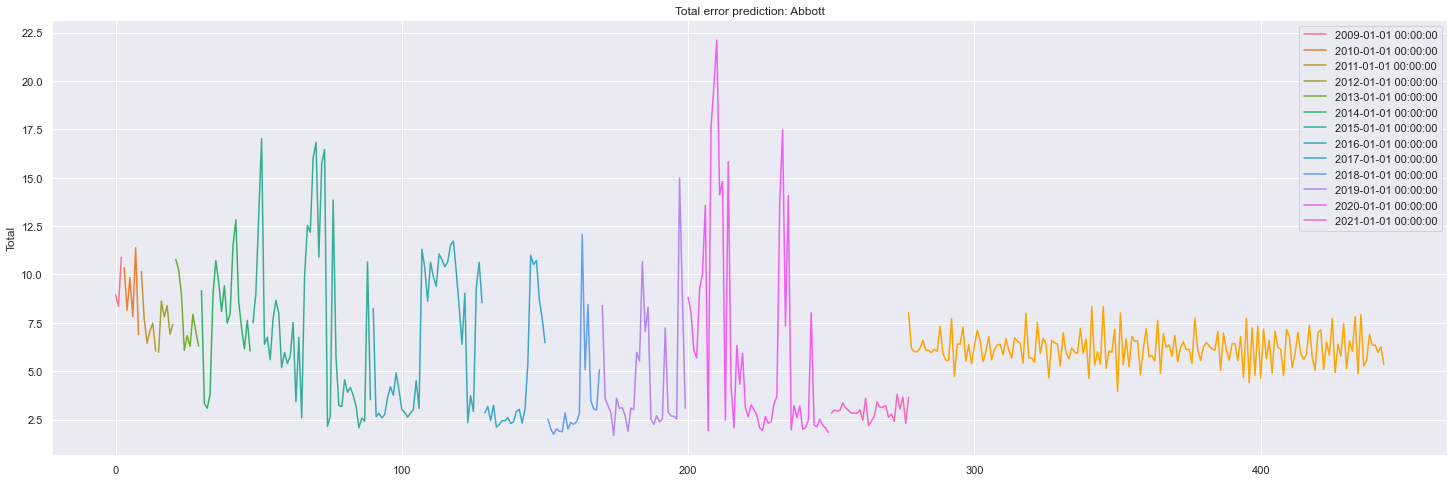

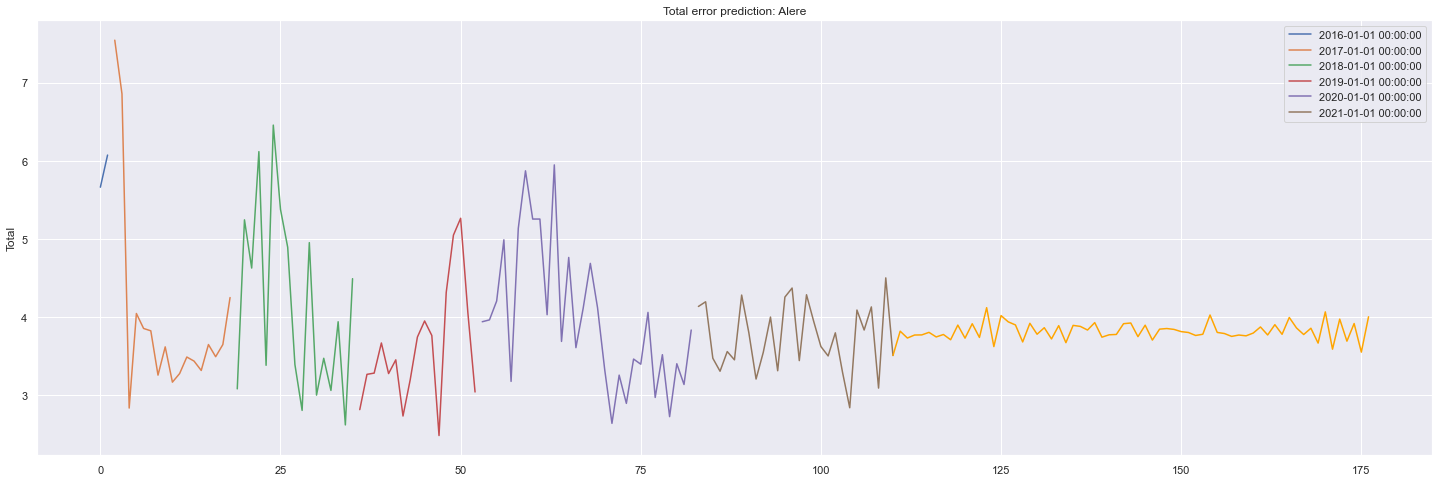

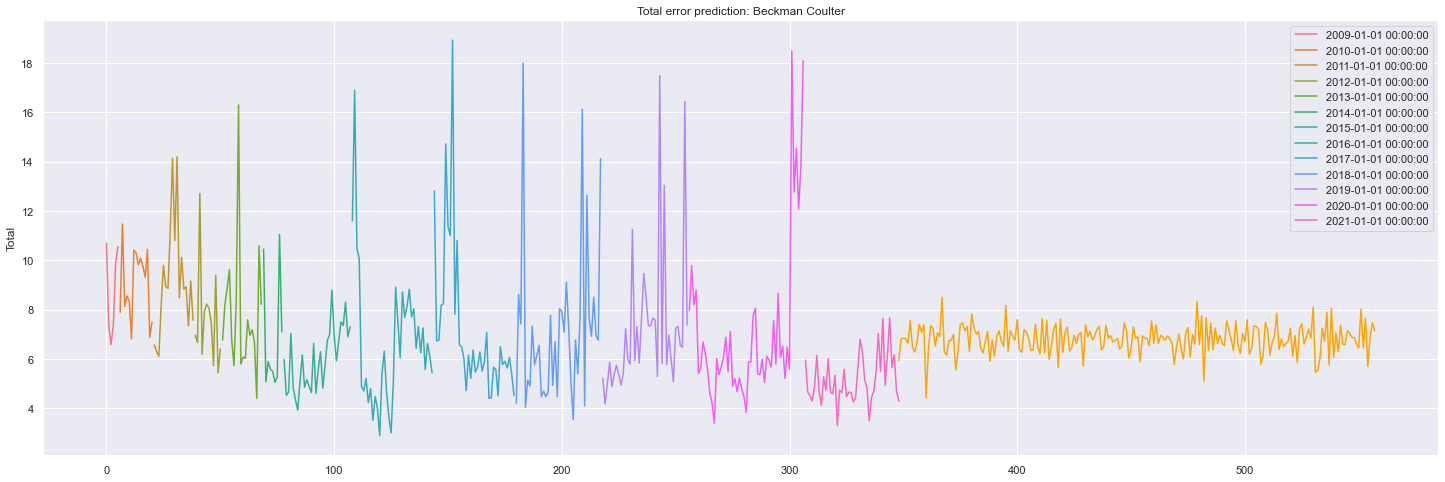

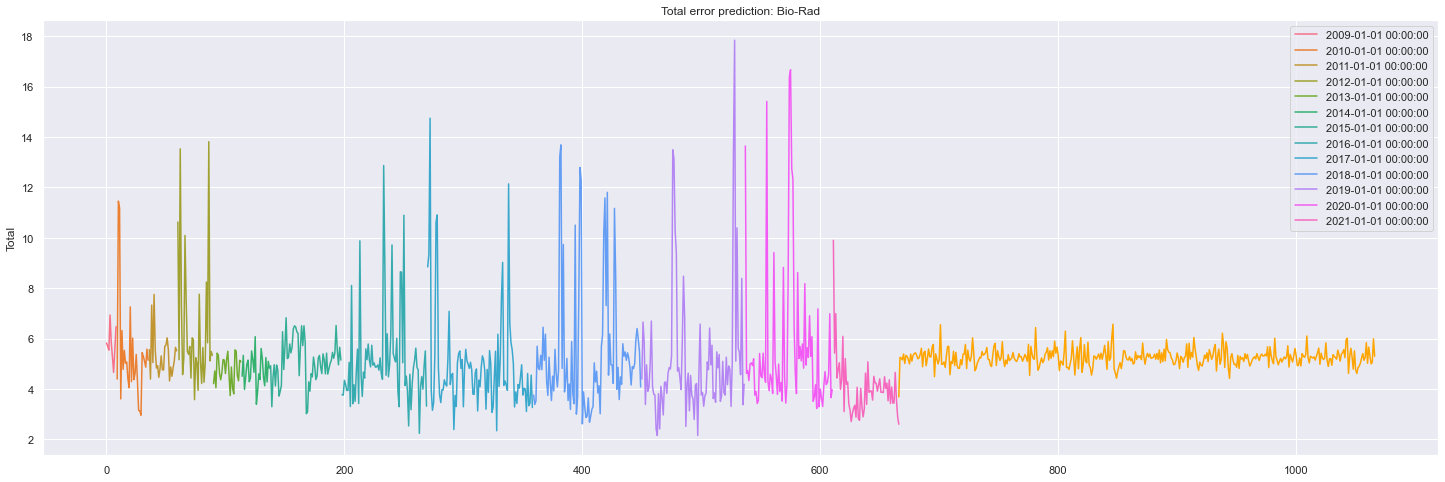

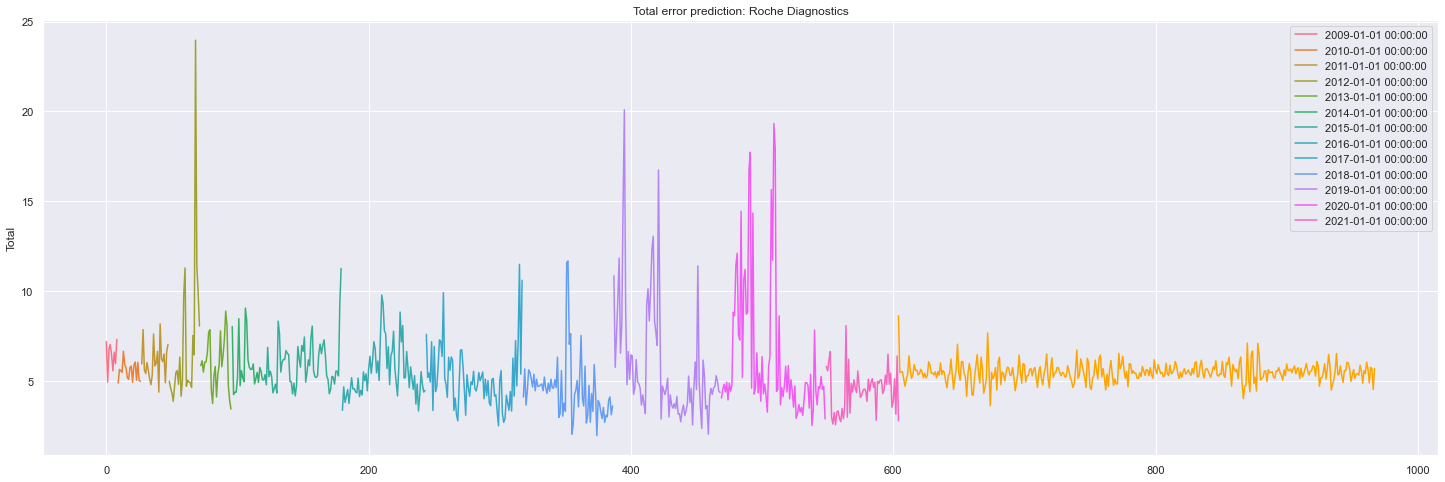

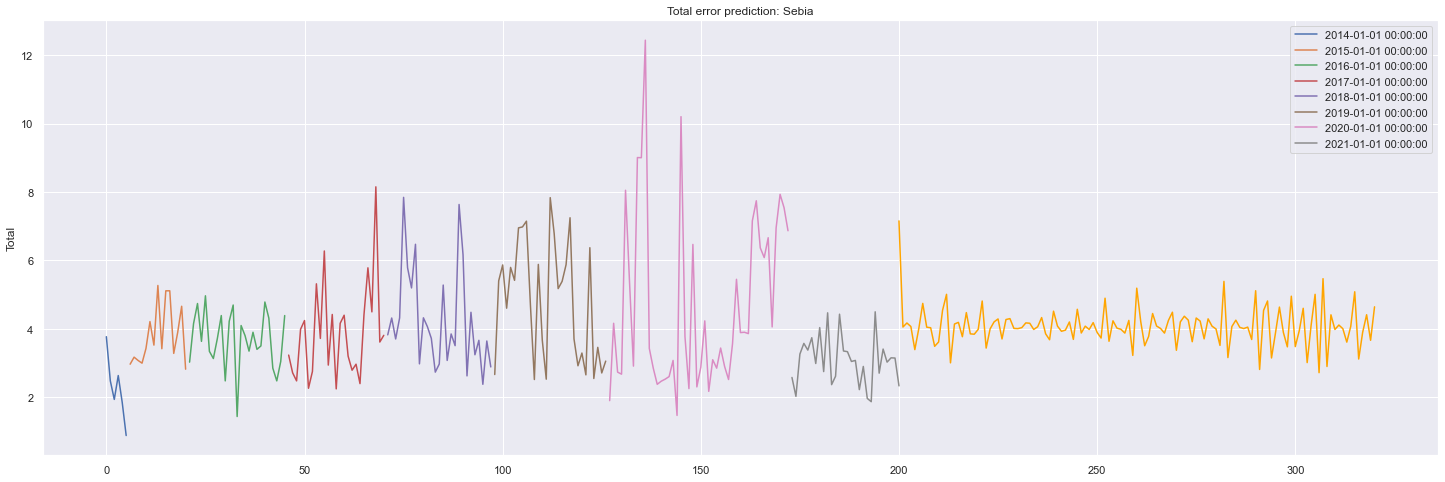

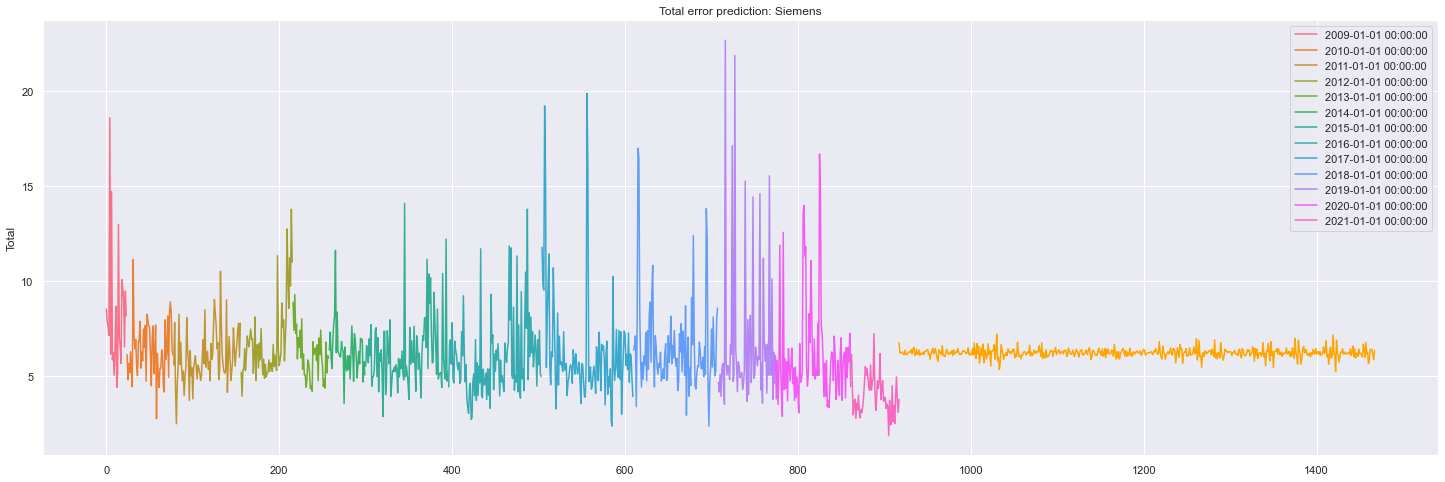

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


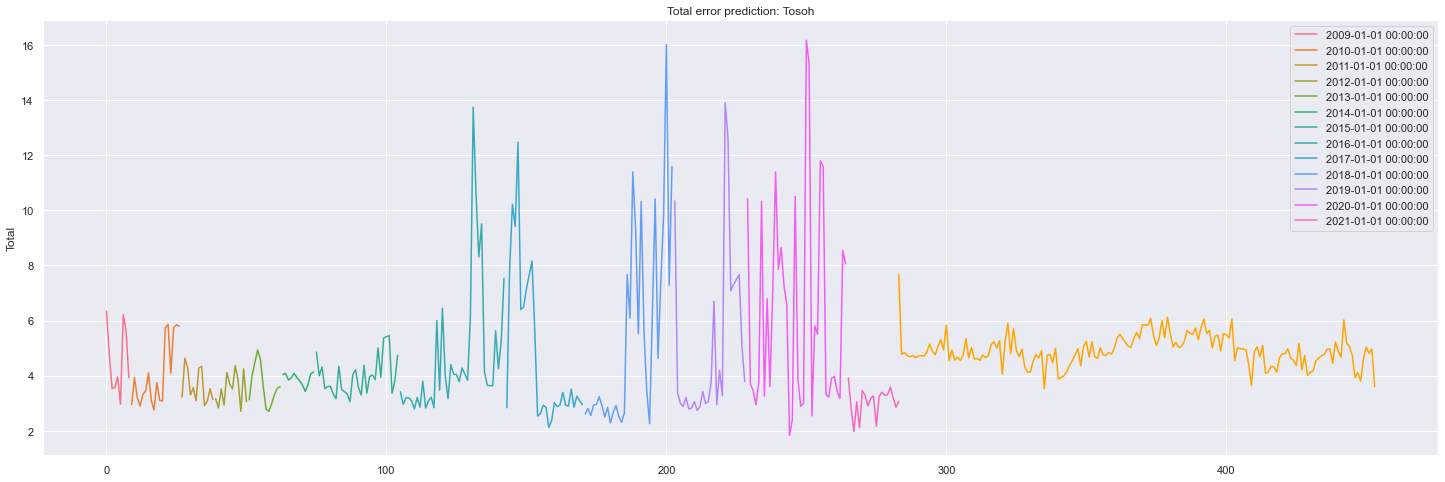

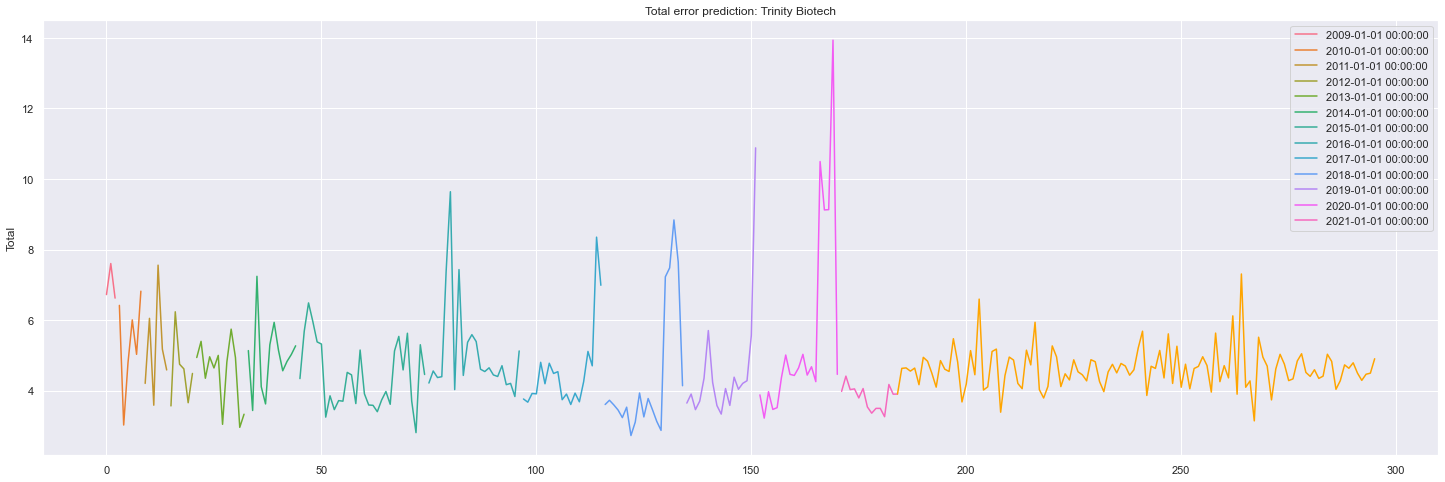

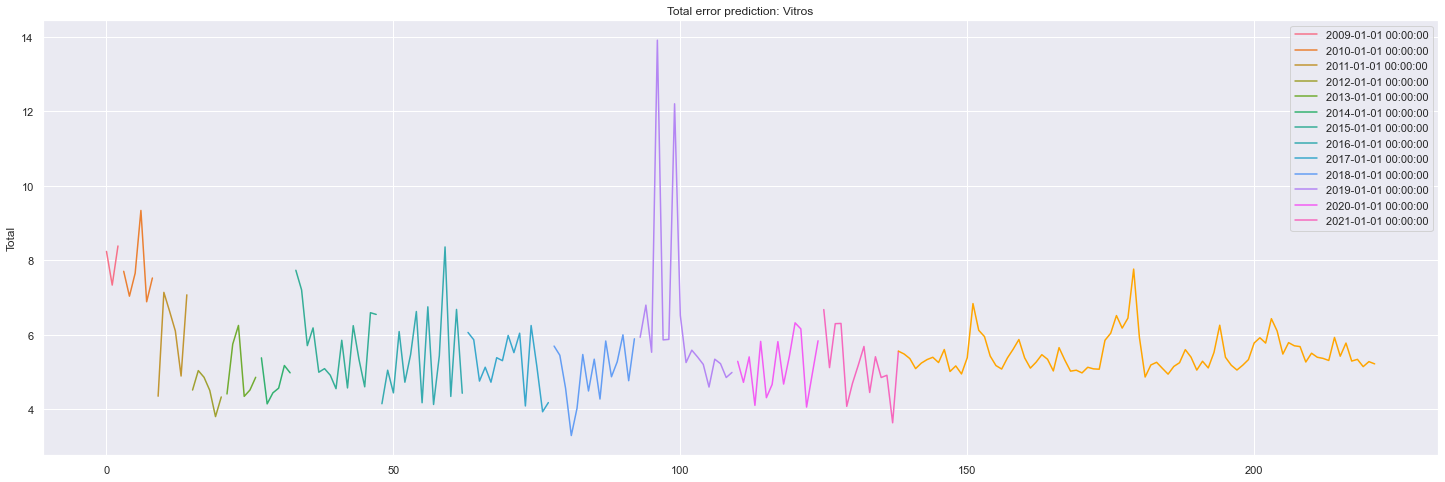

In [36]:
counter= 0
from sklearn.model_selection import train_test_split

import datetime
for name, data in manufacturers:
    tempdf = data[['Total']].dropna()
    X = tempdf.iloc[:, :1].values
    Y = tempdf.index.values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

    model = sm.tsa.arima.ARIMA(X_train, order=(1,0,Lijst_MA[counter]))
    model_fit = model.fit()
    counter = counter +1 #next in list

    y_pred = model_fit.predict(disp=0, exog=None, dynamic=False)
    length_predicted_values = len(y_pred)


    preddf = pd.DataFrame(y_pred, columns=['Total'])
    preddf['Year'] = pd.to_datetime('2022-01-01')
    preddf = preddf.set_index('Year')
    
    
    # Add tempdf and preddf together and reset index
    tempdf = pd.concat([tempdf, preddf], axis=0)

    tempdf.reset_index(inplace=True)
    
    #find predicted value in concatenated dataframe
    start_index_predValues = max(tempdf.index)-length_predicted_values    
    real_values_df = tempdf.loc[:start_index_predValues]
   
    #sort by year and reset index so all years line up
    real_values_df = real_values_df.sort_values(by="Year")
    real_values_df = real_values_df.reset_index()
    
    l = sns.lineplot(x=real_values_df.index, y='Total', data=real_values_df, hue=real_values_df['Year'])
    l.set_title('Total error prediction: ' + name )
    
    #show predicted values
    predict_values_df = tempdf.loc[start_index_predValues:]
    sns.lineplot(x=predict_values_df.index, y='Total', data=predict_values_df, color='orange')
    sns.set(rc = {'figure.figsize':(25,8)})
    plt.show()

# Evaluation


Tijdens het bepalen van de arima modellen zijn bij 2 meetmethoden geen geschikte p-waarden gevonden. Namelijk bij de 'Abott' en 'Roche diagonistics'. Doordat de p-waarde niet onder de 0.05 is, moet er bij de voorspelling van deze meetmethoden rekening worden gehouden met negatieve consequenties, waarbij een groter onzekerheidsgebied garant staat.


#### Conclusie
Er zijn bij alle meetmethoden op te merken dat in het jaar 2022 (oranje-lijntje) een sterke daling of stijging wordt voorspeld, waarbij diverse meetmethoden nog wat pieken gaan krijgen en dan in de meeste gevallen zullen stabiliseren. 


#### Ethische aspecten advies
Het advies voor de opdrachtgever is derhalve om dit model en deze visualisaties slechts als indicatie te gebruiken. Dit wordt uitgewerkt aan de hand van de ethische vraag: 'Kunnen deze visualisaties leiden tot gepaste, ethische conclusies?' 

Precisie

Als het gaat om de waarde 'precisie', zullen deze visualisaties niet leiden tot gepaste ethische conclusies. De metingen die namelijk in de rapporten staan, zijn genoteerd zonder accurate datums. Hierdoor is de voorspelling gemaakt op data waarvan de datums niet bekend zijn, terwijl deze datums bij het gebruikte model een essentieel component zijn. Doordat deze datums niet zijn meegenomen, is de voorspelling derhalve minder nauwkeurig. 

Integriteit

Daarnaast is 'integriteit' een belangrijke waarde bij het beheren van data. We hebben naar deze waarde zoveel mogelijk gestreeft. De HbA1c meetmethoden zijn, door de jaren heen veel veranderd. Zo zijn benamingen van meetmethoden veranderd, waarbij sommige meetmethoden ophielden te bestaan en er later nieuwe meetmethoden bij zijn gekomen. Hierbij valt desondanks niet met zekerheid te zeggen dat de meetmethoden geheel 100% nauwkeurig genormaliseerd zijn. Bij het normaliseren zat veel onderzoek aan vast en door veel desk research is er een meer complete dataset ontwikkeld. 

Privacy

Ten slotte is hier bij de waarde 'privacy' geheel rekening mee gehouden. Alleen openbare, gepubliceerde rapporten zijn gebruikt om deze voorspelling te realiseren. Hier is verder geen data te herleiden naar patiënteninformatie. Verder zijn de fabrikantnamen wel publiekelijk. 


Doordat 'precisie' een belangrijke waarde is voor de product owner, is daarom het advies om deze visualisaties slechts als indicatie te gebruiken en niet als richtlijn. 



Note:
Na een gesprek met de product owner zijn er diverse nieuwe bevindingen voor ons naar voren gekomen. Namelijk dat de samenvoeging van de Amerikaanse en Europese data een vertekend beeld geven en dat de Bias een complex variabele is die verschilt per meting. In dit document is de data samengevoegd en wordt de 'Total error' (total error wordt berekent door middel van onder andere de bias) in kaart gebracht. In overleg met de projectgroep is er besloten om dit model niet aan te passen op de nieuwe bevindingen, omdat dit enerzijds buiten de scope viel en anderszijds door anderen in kaart was gebracht.
